In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
import glob, os
import numpy as np
import networkx as nx
from networkx.utils import py_random_state
import random
import scipy as sp
from scipy.stats import ranksums, ttest_ind

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import ticker, cm

np.set_printoptions(precision=3, linewidth=200, suppress=True)
sns.set_context("poster")
sns.set_style("ticks")


### interpret the fname
def decode_fname(string, keywords):
    strings = string.split('_')
    results = [-1 for _ in keywords]
    for i, string in enumerate(strings):
        for idx, keyword in enumerate(keywords):
            if keyword == '':
                if i == 3:
                    try:
                        results[idx] = string
                    except:
                        continue
            elif keyword in string and keyword[0] == string[0]:
                results[idx] = string.replace(keyword, '')
                try:
                    results[idx] = float(results[idx])
                except:
                    continue
    return results

### collect raw data from a batch of experiments (e.g., 3942 experiments)
def collect_data(task_name, base_dir, pattern, epoch, trainseed_num, seed_start):
    save_dir = 'final_results/{}'.format(task_name)
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    for epoch_cur in range(0,epoch+1):
        print('{}:epoch{}'.format(task_name,epoch_cur))
        os.chdir(base_dir)
        names_all = []
        results_all = []
        for current_dir in glob.glob("*{}*".format(pattern)):
        #     print(current_dir)
            os.chdir('{}/{}'.format(base_dir, current_dir))
            fname = '{}/{}/results_epoch{}.txt'.format(base_dir, current_dir, epoch_cur)
            if os.path.isfile(fname) and 'starttrainseed{}'.format(seed_start) in fname:
                result = np.loadtxt(fname, delimiter=',')
                if len(result.shape)==1:
                    result = result[np.newaxis,:]
                if result.shape[0]>trainseed_num:
                    result = result[-trainseed_num:]
                if result.shape == (trainseed_num,8):
                    names_all.append(decode_fname(current_dir, task_keywords))
                    results_all.append(result)
        names_all = np.stack(names_all, axis=0)
        results_all = np.stack(results_all, axis=0)

        np.save('final_results/{}/names_{}_epoch{}.npy'.format(task_name,task_name,epoch_cur), names_all)
        np.save('final_results/{}/results_{}_epoch{}.npy'.format(task_name,task_name,epoch_cur), results_all)
        
        

        
### align graph_configs and experiment results
def align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, node_num=64, return_sweet_spot=False):
    # process data, compare top model and baseline
    results_mean = np.mean(results_all,axis=1)
    results_std = np.std(results_all,axis=1)
    top1_mean = results_mean[:,3]
    top1_std = results_std[:,3]
    if trainseed_num==1:
        top1_std[:] = 1
    try:
        top1_baseline_mean = float(top1_mean[names_all[:,0]==baseline_transform])
        top1_baseline_std = float(top1_std[names_all[:,0]==baseline_transform])
    except:
        print('baseline not found')
        top1_baseline_mean, top1_baseline_std = 0, 0    
    order = np.argsort(top1_mean)
    if 'linear' in baseline_transform:
        best = order[2] # "best" model in MLP has high variance, pick 2nd best (there is a draw)
    else:
        best = np.argmin(top1_mean)
    print('baseline',round(top1_baseline_mean,2),round(top1_baseline_std,2))
    print('best',round(top1_mean[best],2),round(top1_std[best],2))
    print('top 10\n', np.stack((top1_mean,top1_std),axis=1)[order[:10]].round(2))
    
    # compute statistical significance, for plotting sweet spot
    top1_best = results_all[best,:,3]
    top1_all = results_all[:,:,3]
    significant = []
    for i in range(top1_all.shape[0]):
        stats, p = ttest_ind(top1_best, top1_all[i])
        if stats<0 and p/2 < 0.05:
            significant.append(False)
        else:
            significant.append(True)
    
    # view results over different number of graphs
    graph_configs = np.load('graphs_n{}_{}.npy'.format(node_num, graph_num))
    graph_configs = graph_configs[graph_configs[:,1]<1,:] # excluding complete graph, if provided
    result_final = []
    count = 0
    graph_configs_missing = []
    significant_new = []
    for i in range(graph_configs.shape[0]):
        key = [str(float(round(graph_configs[i,1],6))), str(float(round(graph_configs[i,2],6))), 'sum', str(round(graph_configs[i,3],0))]
        loc = np.where((names_all[:,4:8] == key).all(axis=1))[0]
        if len(loc)>0:
            temp = np.zeros(graph_configs.shape[1]+2)
            temp[:graph_configs.shape[1]] = graph_configs[i,:]
            temp[graph_configs.shape[1]:] = [top1_mean[loc], top1_std[loc]]
            result_final.append(temp)
            significant_new.append(significant[loc[0]])
            count += 1
        else:
            print('not found', key, 'order', i)
            graph_configs_missing.append(i)
    
    # compute sweet spot
    result_temp = np.stack(result_final,axis=0)
    result_temp = result_temp[significant_new]
    print('sweet spot clustering min {}, max {}'.format(result_temp[:,4].min(), result_temp[:,4].max()))
    print('sweet spot path min {}, max {}'.format(result_temp[:,5].min(), result_temp[:,5].max()))
    sweet_spot = [result_temp[:,4].min(), result_temp[:,5].min(),
                 result_temp[:,4].max() - result_temp[:,4].min(),
                 result_temp[:,5].max() - result_temp[:,5].min()]
            
    # add baseline result
    if top1_baseline_mean>0:
        result_final.append(np.array([node_num,1,0,0,1,1,top1_baseline_mean,top1_baseline_std]))
    result_final = np.stack(result_final,axis=0)
    
    if return_sweet_spot:
        return result_final, sweet_spot
    else:
        return result_final
    

### align graph_configs and experiment results for each bin
# used when multiple graphs present in a bin
def align_results_bin(names_all, results_all, trainseed_num, baseline_transform, graph_num, node_num=64, return_sweet_spot=False):    
    ### View results over different number of graphs
    graph_configs = np.load('graphs_n{}_{}.npy'.format(node_num, graph_num))

    graph_configs = graph_configs[graph_configs[:,1]<1,:]
    result_final = []
    graph_configs_missing = []
    significant_new = []
    for i in range(graph_configs.shape[0]):
        key = [str(float(round(graph_configs[i,1],6))), str(float(round(graph_configs[i,2],6))), 'sum', str(round(graph_configs[i,3],0))]
        loc = np.where((names_all[:,4:8] == key).all(axis=1))[0]
        if len(loc)>0:
            for j in range(results_all.shape[1]):
                temp = np.zeros(graph_configs.shape[1]+2)
                temp[:graph_configs.shape[1]] = graph_configs[i,:]
                temp[graph_configs.shape[1]:] = [results_all[loc,j,3], 1]
                result_final.append(temp)
        else:
            print('not found', key, 'order', i)
            graph_configs_missing.append(i)    
    try:
        baseline_id = names_all[:,0]==baseline_transform
    except:
        print('baseline not found')
        baseline_id = None
    result_baseline = results_all[baseline_id[0]]
    for i in range(result_baseline.shape[0]):
        result_final.append(np.array([node_num,1,0,0,1,1,result_baseline[i,3],1]))
    result_final = np.stack(result_final,axis=0)
        
    bin_num = 52
    result_plot = result_final
    ### node=64
    # 3942 graphs
    if bin_num == 3942:
        bins_clustering = np.linspace(0,1,15*9+1) # clustering
        bins_path = np.linspace(1,4.5,15*9+1) # path
        bins_sparsity = np.linspace(0,1,15*9+1) # sparsity
    # 449 graphs
    if bin_num == 449:
        bins_clustering = np.linspace(0,1,15*3+1) # clustering
        bins_path = np.linspace(1,4.5,15*3+1) # path
        bins_sparsity = np.linspace(0,1,15*3+1) # sparsity
    # 52 graphs
    if bin_num == 52:
        bins_clustering = np.linspace(0,1,15+1) # clustering
        bins_path = np.linspace(1,4.5,15+1) # path
        bins_sparsity = np.linspace(0,1,15+1) # sparsity
        # filter to 52 graphs, if necessary
        graph_configs_52 = np.load('graphs_n64_52.npy')
        graph_configs_52 = np.concatenate((graph_configs_52,[[-1,-1,-1,-1,1,1]]))
    
    # clustering: 4; path: 5
    digits_clustering = np.digitize(result_plot[:,4],bins_clustering,right=True)
    digits_path = np.digitize(result_plot[:,5],bins_path)

    ### path, clustering
    result_sum = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
    result_count = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
    result_collection = {}
    measure_collection = {}
    for i in range(digits_clustering.shape[0]):
        result_sum[digits_path[i], digits_clustering[i]] += result_plot[i,-2]
        result_count[digits_path[i], digits_clustering[i]] += 1
        if digits_clustering[i]+1 < bins_clustering.shape[0] and digits_path[i]+1 < bins_path.shape[0]:
            clustering = (bins_clustering[digits_clustering[i]-1] + bins_clustering[digits_clustering[i]])/2
            path = (bins_path[digits_path[i]-1] + bins_path[digits_path[i]])/2
        else:
            clustering = bins_clustering[digits_clustering[i]]
            path = bins_path[digits_path[i]]
        if result_collection.get((digits_path[i], digits_clustering[i])) is None:
            result_collection[(digits_path[i], digits_clustering[i])] = [result_plot[i,-2]]
        else:
            result_collection[(digits_path[i], digits_clustering[i])].append(result_plot[i,-2])
        measure_collection[(digits_path[i], digits_clustering[i])] = [clustering, path]
    
    result_mean = result_sum/result_count    
    result_temp = result_mean.copy()
    result_temp[np.isnan(result_temp)] = 100
    best_id = np.unravel_index(result_temp.argmin(), result_temp.shape)
    result_best = result_collection[best_id]
    print('best', result_best)
    significant = []
    for key,val in result_collection.items():
        stats, p = ttest_ind(result_best, val)
        if stats<0 and p/2 < 0.05:
            pass
        else:
            significant.append(key)

    measures = []
    for key in significant:
        measures.append(measure_collection[key])
    measures = np.array(measures)
    sweet_spot = [measures[:,0].min(), measures[:,1].min(),
                 measures[:,0].max() - measures[:,0].min(),
                 measures[:,1].max() - measures[:,1].min(),]
    print('sweet spot clustering min {}, max {}'.format(measures[:,0].min(), measures[:,0].max()))
    print('sweet spot path min {}, max {}'.format(measures[:,1].min(), measures[:,1].max()))        
    
    if return_sweet_spot:
        return result_final, sweet_spot
    else:
        return result_final
        

    
def sort_results(names_all, results_all):
    rank_base = [names_all[:, i].astype(str) for i in range(names_all.shape[1])][::-1]
    order = np.lexsort(rank_base)
    names_all = names_all[order]
    results_all = results_all[order]
    return names_all, results_all



def compute_count(channel, group):
    divide = channel//group
    remain = channel%group

    out = np.zeros(group, dtype=int)
    out[:remain]=divide+1
    out[remain:]=divide
    return out

@py_random_state(3)
def ws_graph(n, k, p, seed=1):
    """Returns a ws-flex graph, k can be real number in [2,n]
    """
    assert k>=2 and k<=n
    # compute number of edges:
    edge_num = int(round(k*n/2))
    count = compute_count(edge_num, n)
    G = nx.Graph()
    for i in range(n):
        source = [i]*count[i]
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        G.add_edges_from(zip(source, target))
    # rewire edges from each node
    nodes = list(G.nodes())
    for i in range(n):
        u = i
        target = range(i+1,i+count[i]+1)
        target = [node%n for node in target]
        for v in target:
            if seed.random() < p:
                w = seed.choice(nodes)
                # Enforce no self-loops or multiple edges
                while w == u or G.has_edge(u, w):
                    w = seed.choice(nodes)
                    if G.degree(u) >= n - 1:
                        break  # skip this rewiring
                else:
                    G.remove_edge(u, v)
                    G.add_edge(u, w)
    return G

@py_random_state(4)
def connected_ws_graph(n, k, p, tries=100, seed=1):
    """Returns a connected ws-flex graph.
    """
    for i in range(tries):
        # seed is an RNG so should change sequence each call
        G = ws_graph(n, k, p, seed)
        if nx.is_connected(G):
            return G
    raise nx.NetworkXError('Maximum number of tries exceeded')

def generate_graph(message_type='ws', n=16, sparsity=0.5, p=0.2,
                   directed=False, seed=123):
    degree = n*sparsity
    if message_type == 'ws':
        graph = connected_ws_graph(n=n, k=degree, p=p, seed=seed)
    return graph


def extend_bin(bin):
    step = bin[1]-bin[0]
    bin = np.insert(bin, 0, bin[0]-step)
    bin = np.append(bin, bin[-1]+step)
    return bin

            
            
### 2-D graph stats vs. NN performance
def plot_2d(result_final, task_name, bin_num, simple=False, mark_best=True, sweet_spot=None, save_npy=False):
    cbar_label = 'Top-1 Error (%)'
    result_plot = result_final

    ### node=64
    # 3942 graphs
    if bin_num == 3942:
        bins_clustering = np.linspace(0,1,15*9+1) # clustering
        bins_path = np.linspace(1,4.5,15*9+1) # path
        bins_sparsity = np.linspace(0,1,15*9+1) # sparsity
    # 449 graphs
    if bin_num == 449:
        bins_clustering = np.linspace(0,1,15*3+1) # clustering
        bins_path = np.linspace(1,4.5,15*3+1) # path
        bins_sparsity = np.linspace(0,1,15*3+1) # sparsity
    # 52 graphs
    if bin_num == 52:
        bins_clustering = np.linspace(0,1,15+1) # clustering
        bins_path = np.linspace(1,4.5,15+1) # path
        bins_sparsity = np.linspace(0,1,15+1) # sparsity
        # filter to 52 graphs, if necessary
        graph_configs_52 = np.load('graphs_n64_52.npy')
        graph_configs_52 = np.concatenate((graph_configs_52,[[-1,-1,-1,-1,1,1]]))
    ### node=16
    # 48 graphs
    if bin_num == 48:
        bins_clustering = np.linspace(0,1,12+1) # clustering
        bins_path = np.linspace(1,2.5,12+1) # path
    # 326 graphs
    if bin_num == 326:
        bins_clustering = np.linspace(0,1,12*3+1) # clustering
        bins_path = np.linspace(1,2.5,12*3+1) # path
    # 2698 graphs
    if bin_num == 2698:
        bins_clustering = np.linspace(0,1,12*9+1) # clustering
        bins_path = np.linspace(1,2.5,12*9+1) # path
    
    # clustering: 4; path: 5
    digits_clustering = np.digitize(result_plot[:,4],bins_clustering,right=True)
    digits_path = np.digitize(result_plot[:,5],bins_path)
    print('clustering', digits_clustering.min(), digits_clustering.max(), len(bins_clustering))
    print('path', digits_path.min(), digits_path.max(), len(bins_path))

    ### path, clustering
    result_sum = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
    result_count = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
    for i in range(digits_clustering.shape[0]):
        result_sum[digits_path[i], digits_clustering[i]] += result_plot[i,-2]
        result_count[digits_path[i], digits_clustering[i]] += 1
    result_mean = result_sum/result_count

    ### filter to 52 graphs
    if bin_num == 52:
        digits_clustering_52 = np.digitize(graph_configs_52[:,-2],bins_clustering,right=True)
        digits_path_52 = np.digitize(graph_configs_52[:,-1],bins_path)
        result_mean_filtered = np.empty((len(bins_path)+1, len(bins_clustering)+1))
        result_mean_filtered[:] = np.nan
        for i in range(graph_configs_52.shape[0]):
            result_mean_filtered[digits_path_52[i],digits_clustering_52[i]] = result_mean[digits_path_52[i],digits_clustering_52[i]]
        result_mean = result_mean_filtered

    # path
    color = result_mean
    len_max = 0
    col_id = 0
    for i in range(color.shape[1]):
        color_col = color[:,i]
        len_cur = len(color_col[~np.isnan(color_col)])
        if len_cur>len_max:
            len_max = len_cur
            col_id = i
    
    color_col = color[:,col_id]
    color_col = color_col[~np.isnan(color_col)]
    
    ### plot
    sns.set_context("poster")
    fig = plt.figure(figsize=(15,20))
    ax = fig.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ##### Note: the x,y ordering is reversed for plotting
    ### path, clustering
    surf = ax.pcolorfast(extend_bin(bins_clustering), extend_bin(bins_path), color,
                         cmap=plt.cm.Blues_r, vmin=color[~np.isnan(color)].min(), vmax=color[~np.isnan(color)].max())
    if mark_best:
        if 'cifar' in task_name and bin_num == 3942:
            best_id = 3552
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
        if 'cnn6_imagenet' in task_name:
            best_id = 27
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
        if 'resnet34_imagenet' in task_name:
            best_id = 37
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
        if 'resnet34_sep_imagenet' in task_name:
            best_id = 36
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
        if 'resnet50_imagenet' in task_name:
            best_id = 22
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
        if 'efficient_imagenet' in task_name:
            best_id = 42
            plt.scatter(result_plot[best_id,4],result_plot[best_id,5],
                    s=500, linewidth=10, c='#b02318', marker='x')
    
    if sweet_spot is not None:
        rect = patches.Rectangle((sweet_spot[0],sweet_spot[1]),sweet_spot[2],sweet_spot[3],
                                 linewidth=5,edgecolor='#b02318',facecolor='none',linestyle='--')
        ax.add_patch(rect)
        
    if simple:
        plt.xlabel('C', fontsize=60)
        plt.ylabel('L', fontsize=60)
        plt.xticks(fontsize=56)
        plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5],fontsize=56)
    else:
        plt.xlabel('Clustering Coefficient (C)', fontsize=48)
        plt.ylabel('Average Path Length (L)', fontsize=48)
        plt.xticks(fontsize=40)
        plt.yticks([1,1.5,2,2.5,3,3.5,4,4.5],fontsize=40)

    plt.gca().tick_params(axis='x', pad=15)
    plt.gca().tick_params(axis='y', pad=15)

    if 'cifar' in task_name and bin_num == 52:
        cbar = fig.colorbar(surf, shrink=0.8, aspect=16, pad=0.15, orientation='horizontal',
                   ticks=[32.5, 32.9, 33.3])
    else:
        cbar = fig.colorbar(surf, shrink=0.8, aspect=16, pad=0.15, orientation='horizontal')
        tick_locator = ticker.MaxNLocator(nbins=4)
        cbar.locator = tick_locator
        cbar.update_ticks()
        
    if simple:
        cbar.set_label(cbar_label, rotation=0, labelpad=10, fontsize=56)
        cbar.ax.tick_params(labelsize=56)
    else:
        cbar.set_label(cbar_label, rotation=0, labelpad=10, fontsize=48)
        cbar.ax.tick_params(labelsize=40)

    if simple:
        plt.savefig('final_results/figs/{}_resolution{}_simple.png'.format(task_name, bin_num),dpi=100,bbox_inches='tight')
    else:
        plt.savefig('final_results/figs/{}_resolution{}.png'.format(task_name, bin_num),dpi=125,bbox_inches='tight')

    if save_npy:
        np.save('final_results/npys/{}_resolution{}.npy'.format(task_name, bin_num),color[~np.isnan(color)])

### 1-D slice of graph stats vs. NN performance        
def plot_1d_slice(result_final, task_name, title_name, more_stats=None):
    sns.set_context("poster")
    sns.set_style("ticks")

    current_palette = sns.color_palette('muted',n_colors=5)
    title = '{}'.format(title_name)

    point_color = '#a9a9a9'
    line_color = current_palette[0]
    line_width = 10
    point_size = 100
    
    # fix range of clustering
    result_plot = result_final[np.logical_and(result_final[:,4]>=0.4, result_final[:,4]<=0.6)]

    fig = plt.figure(figsize=(16,15))
    ax = plt.gca()
    if 'resnet' in task_name:
        ax.set_xlim(1.25, 3.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    sns.regplot(result_plot[:,5],result_plot[:,-2], order=2, scatter_kws={'s':point_size, 'color':point_color}, line_kws={'linewidth':line_width, 'color':line_color},ci=None, truncate=False)
    plt.xlabel('L', fontsize=80)
    plt.ylabel('Top-1 Error', fontsize=80)
    plt.xticks([1.0,1.5,2,2.5,3,3.5], fontsize=72)
    plt.yticks(fontsize=72)
    plt.savefig('final_results/figs/{}_1dslice_path.png'.format(task_name),dpi=75,bbox_inches='tight')        
    plt.show()
    
    # fix range of path
    result_plot = result_final[np.logical_and(result_final[:,5]>=2, result_final[:,5]<=2.5)]
    
    fig = plt.figure(figsize=(16,15))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.regplot(result_plot[:,4],result_plot[:,-2], order=2, scatter_kws={'s':point_size, 'color':point_color}, line_kws={'linewidth':line_width, 'color':line_color},ci=None, truncate=False)
    plt.xlabel('C', fontsize=80)
    plt.ylabel('Top-1 error', fontsize=80)
    plt.xticks([0,0.2,0.4,0.6,0.8], fontsize=72)
    plt.yticks(fontsize=72)
    plt.savefig('final_results/figs/{}_1dslice_cluster.png'.format(task_name),dpi=75,bbox_inches='tight')
    plt.show()
        

In [ ]:
### Only run this block if you want to analyze raw data
### SKIP this block if you want to analyze with provided data
comment = 'v1'
task_keywords = ['trans','talkmode','num',
    'message','sparsity','p', 'agg',
    'graphseed','starttrainseed','endtrainseed','keep',
    'add1x1','upper','match','epoch'
    ]

### Example: loading experimental results from mlp_cifar10
task_name = 'mlp_cifar10'
base_dir = "/path_to_checkpoints/mlp_cifar10" # path to experiment results
pattern = 'mlp_bs128_1gpu_layer3'
epoch = 200
trainseed_num = 5
seed_start = 1
collect_data(task_name, base_dir, pattern, epoch, trainseed_num, seed_start)

mlp_cifar10 (3943, 15) (3943, 5, 8)
baseline 33.34 0.36
best 32.05 0.14
top 10
 [[31.98  0.45]
 [32.05  0.42]
 [32.05  0.14]
 [32.07  0.24]
 [32.09  0.28]
 [32.09  0.16]
 [32.1   0.3 ]
 [32.1   0.3 ]
 [32.11  0.39]
 [32.11  0.38]]
sweet spot clustering min 0.09065856018981022, max 0.7186548913043471
sweet spot path min 1.632936507936508, max 3.0421626984126986


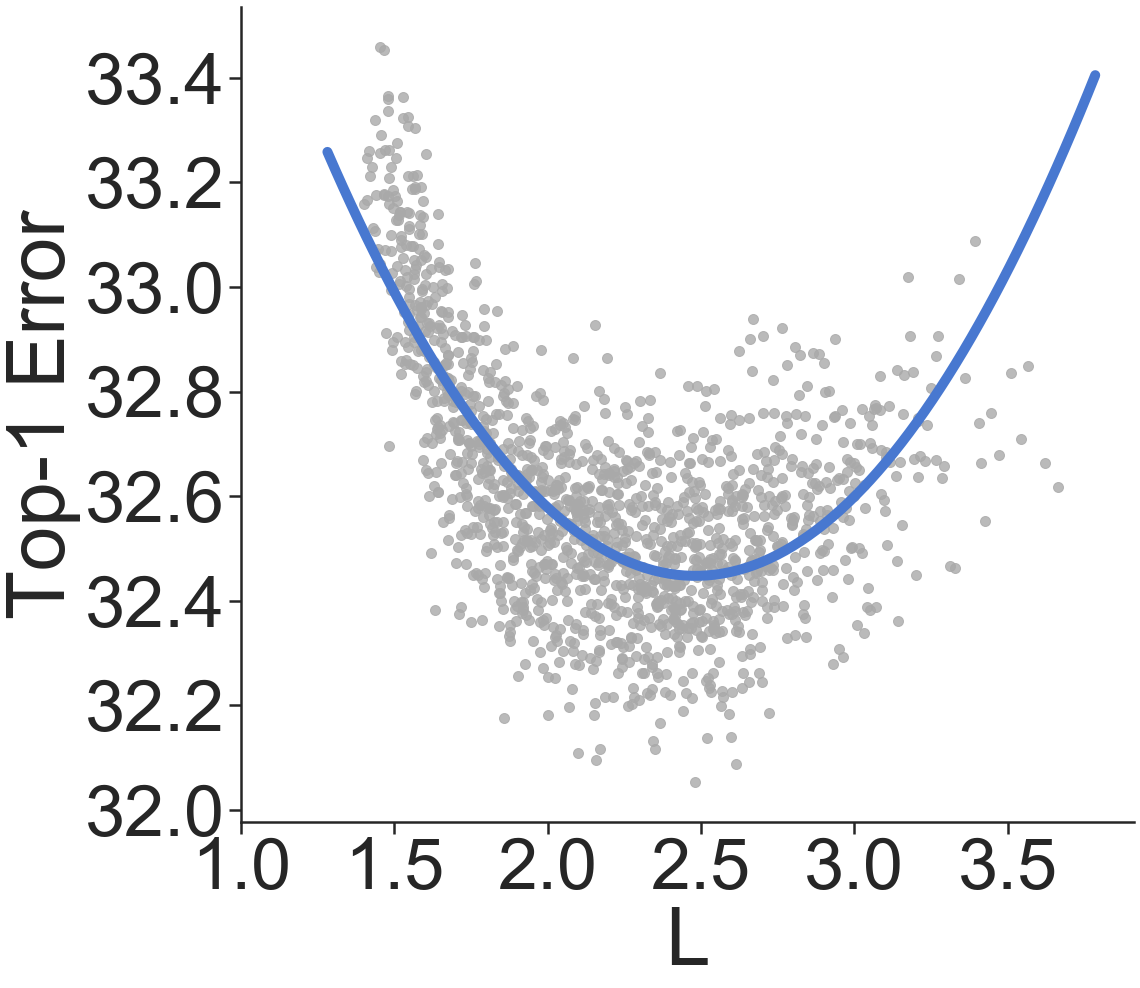

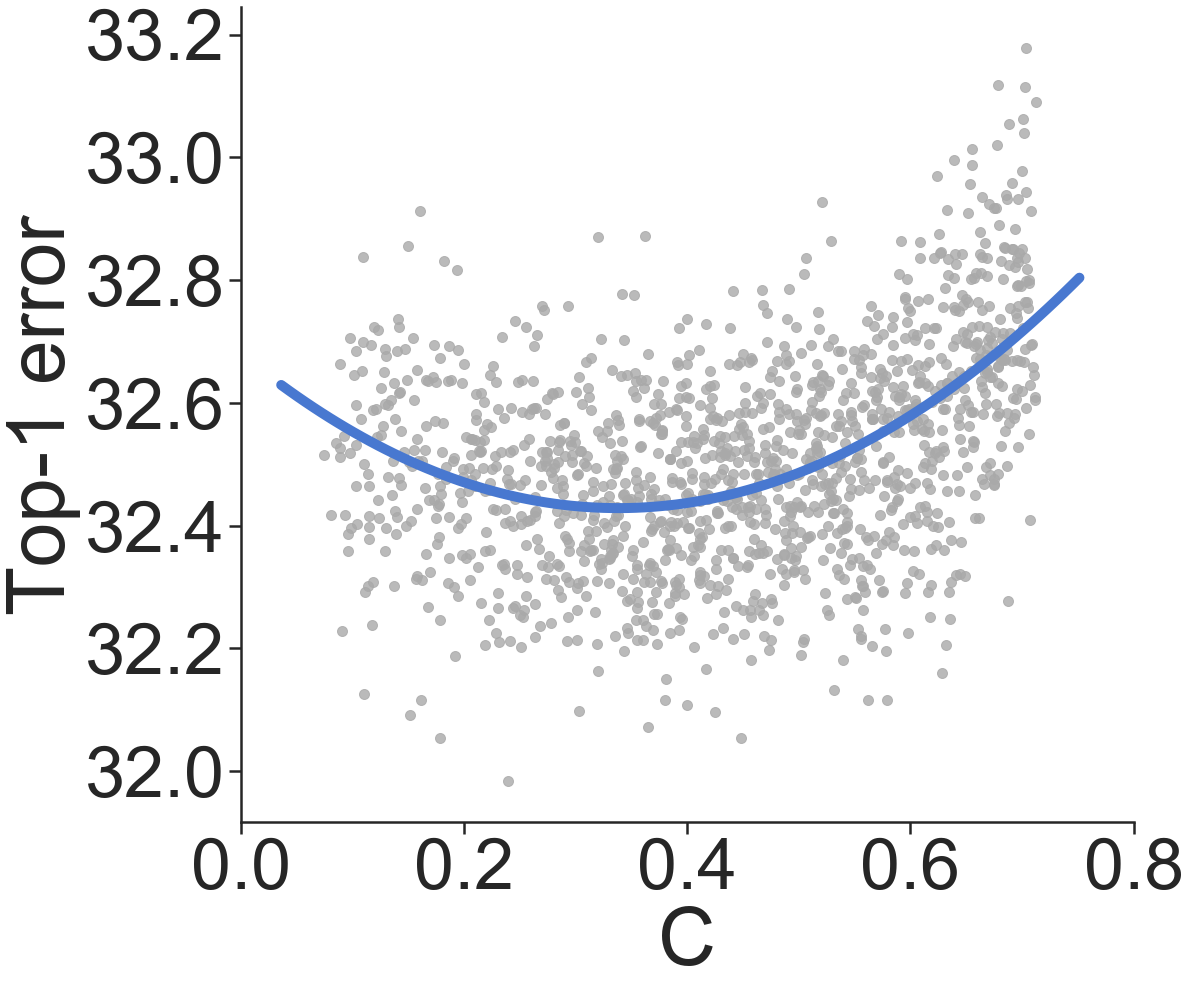

clustering 11 135 136
path 1 133 136


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in true_divide
/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in true_divide


best [33.0, 31.87, 32.42, 32.42, 32.06, 32.34, 32.5, 32.38, 32.19, 32.12, 32.35, 31.98, 32.27, 32.46, 32.67]
sweet spot clustering min 0.1, max 0.5
sweet spot path min 1.8166666666666667, max 2.75
clustering 2 15 16
path 1 15 16


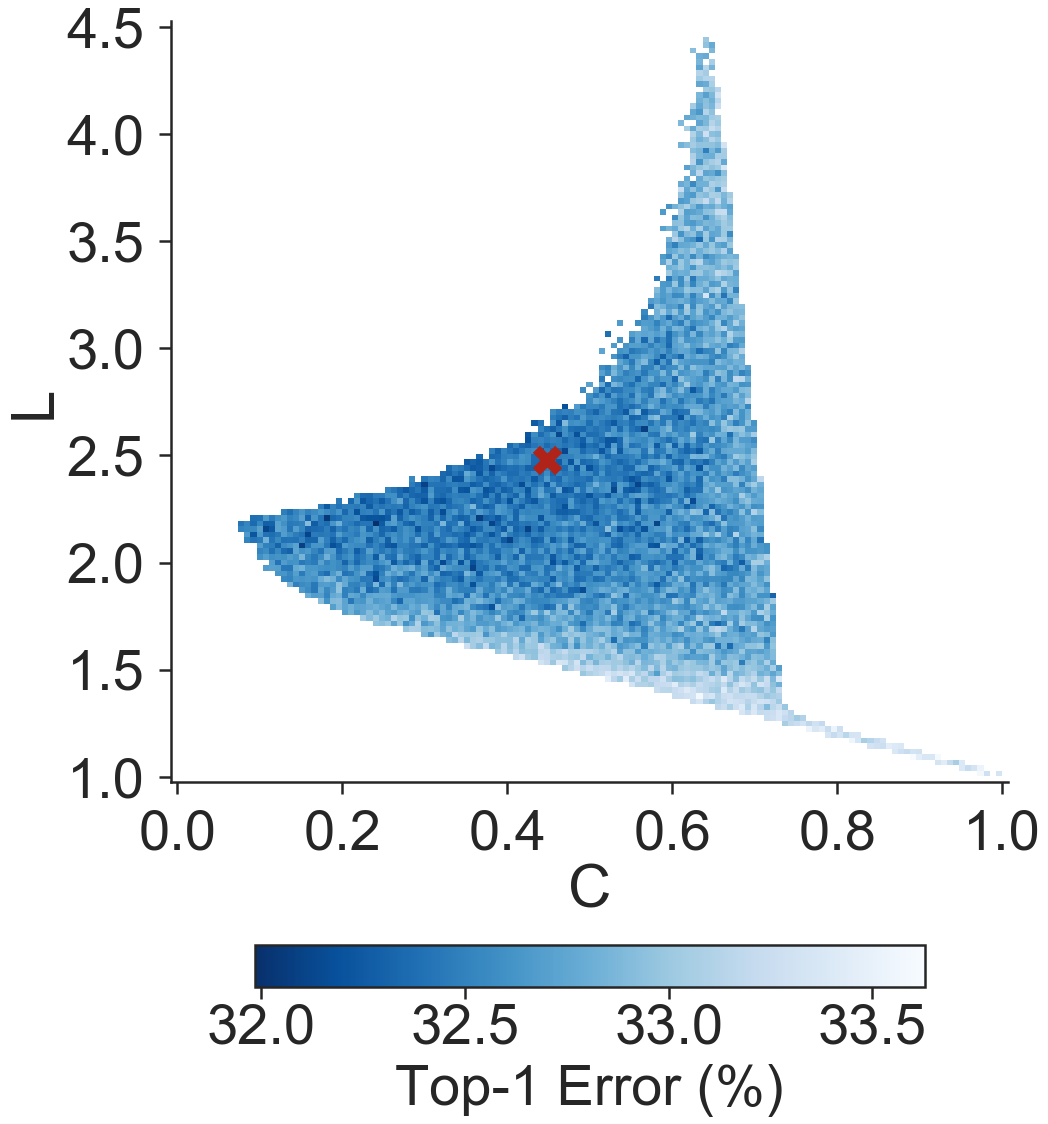

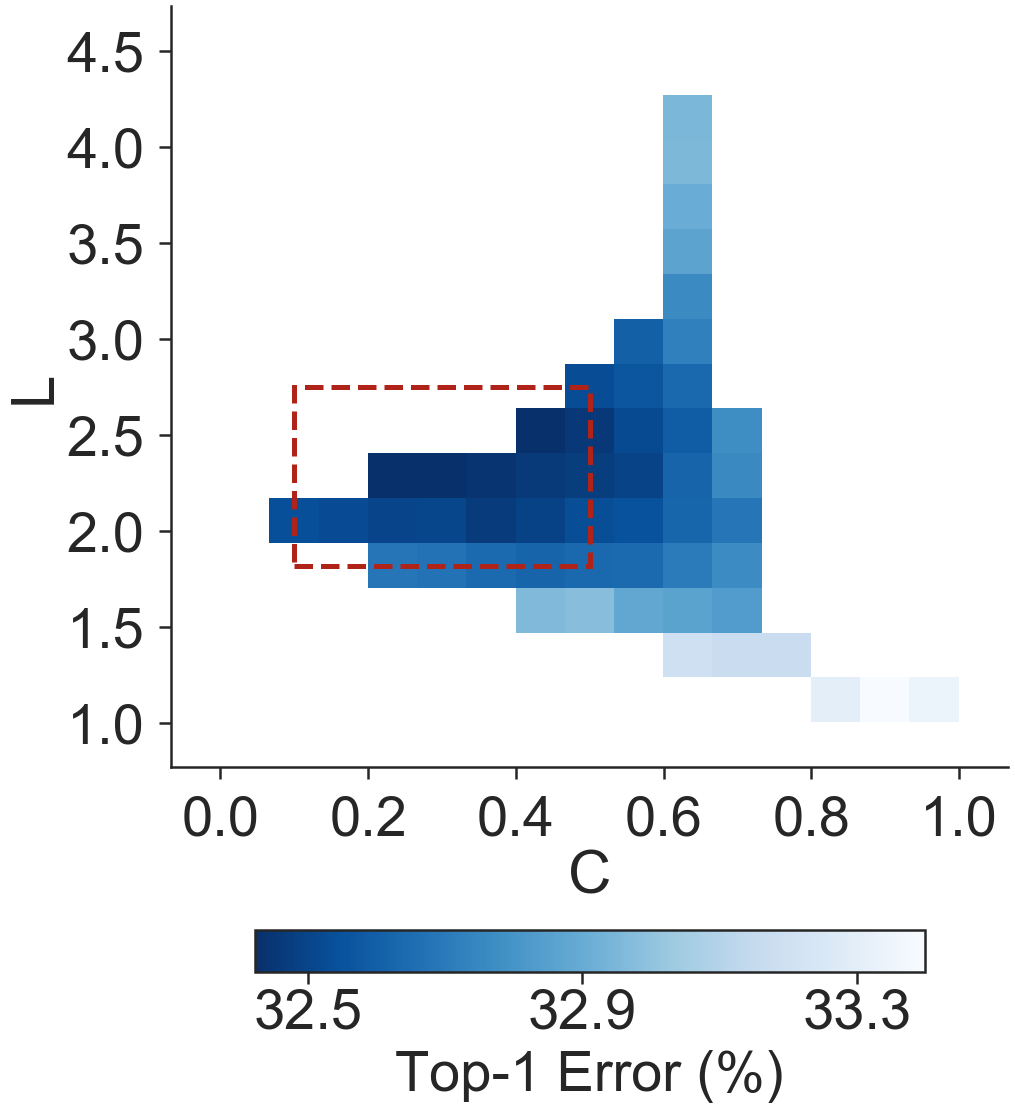

In [3]:
### Plots for MLP on CIFAR10
task_name = 'mlp_cifar10'
title_name = '5-layer 512-d MLP on Cifar-10'
trainseed_num = 5
epoch = 200
baseline_transform = 'linear'
graph_num = 3942

names_all = np.load('final_results/{}/names_{}_epoch{}.npy'.format(task_name, task_name, epoch))
results_all = np.load('final_results/{}/results_{}_epoch{}.npy'.format(task_name, task_name, epoch))
print(task_name, names_all.shape, results_all.shape)
    
result_final = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [3942] if i<=graph_num]
for bin_num in bin_range:
    plot_2d(result_final, task_name, bin_num, simple=True)
    
result_final, sweet_spot = align_results_bin(names_all, results_all, trainseed_num, baseline_transform, graph_num, return_sweet_spot=True)
bin_range = [i for i in [52] if i<=graph_num]
for bin_num in bin_range:
    plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

cnn6_imagenet (53, 15) (53, 3, 8)
baseline 48.27 0.14
best 46.73 0.16
top 10
 [[46.73  0.16]
 [46.73  0.02]
 [46.74  0.08]
 [46.76  0.13]
 [46.77  0.14]
 [46.83  0.13]
 [46.84  0.11]
 [46.84  0.14]
 [46.84  0.06]
 [46.85  0.07]]
sweet spot clustering min 0.2998069052067215, max 0.7025487307076977
sweet spot path min 1.5719246031746033, max 2.7524801587301586


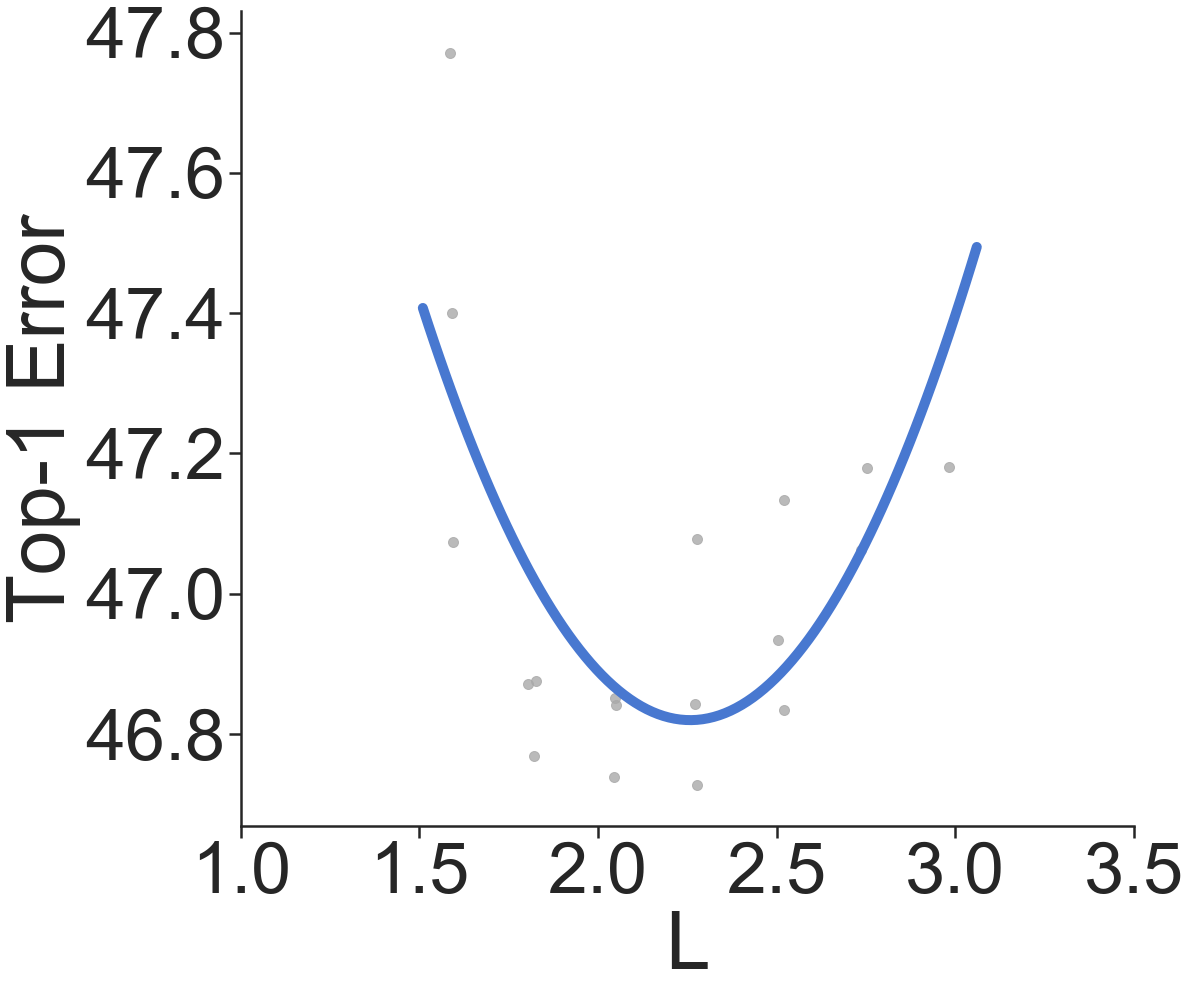

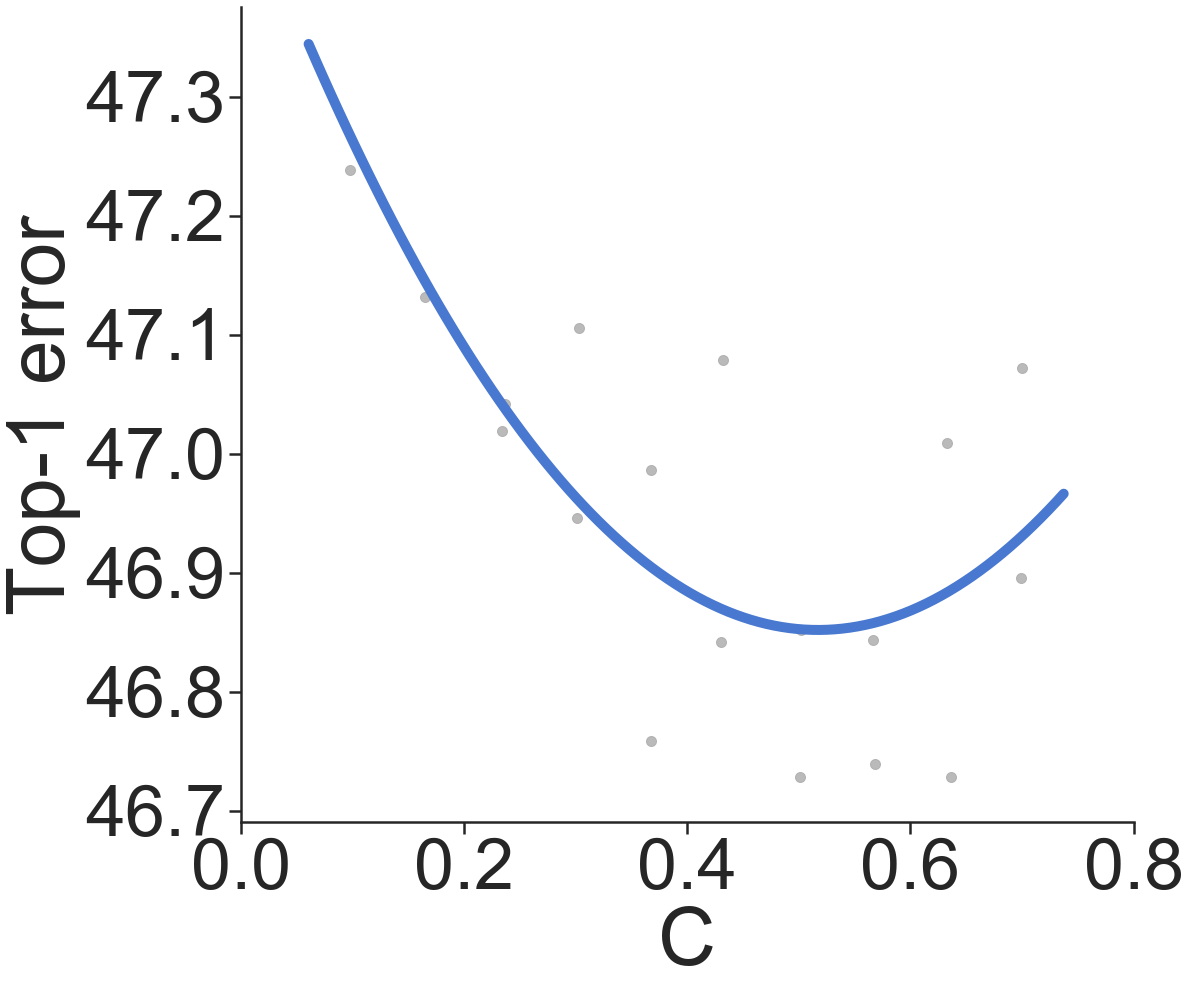

clustering 2 15 16
path 1 14 16


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in true_divide


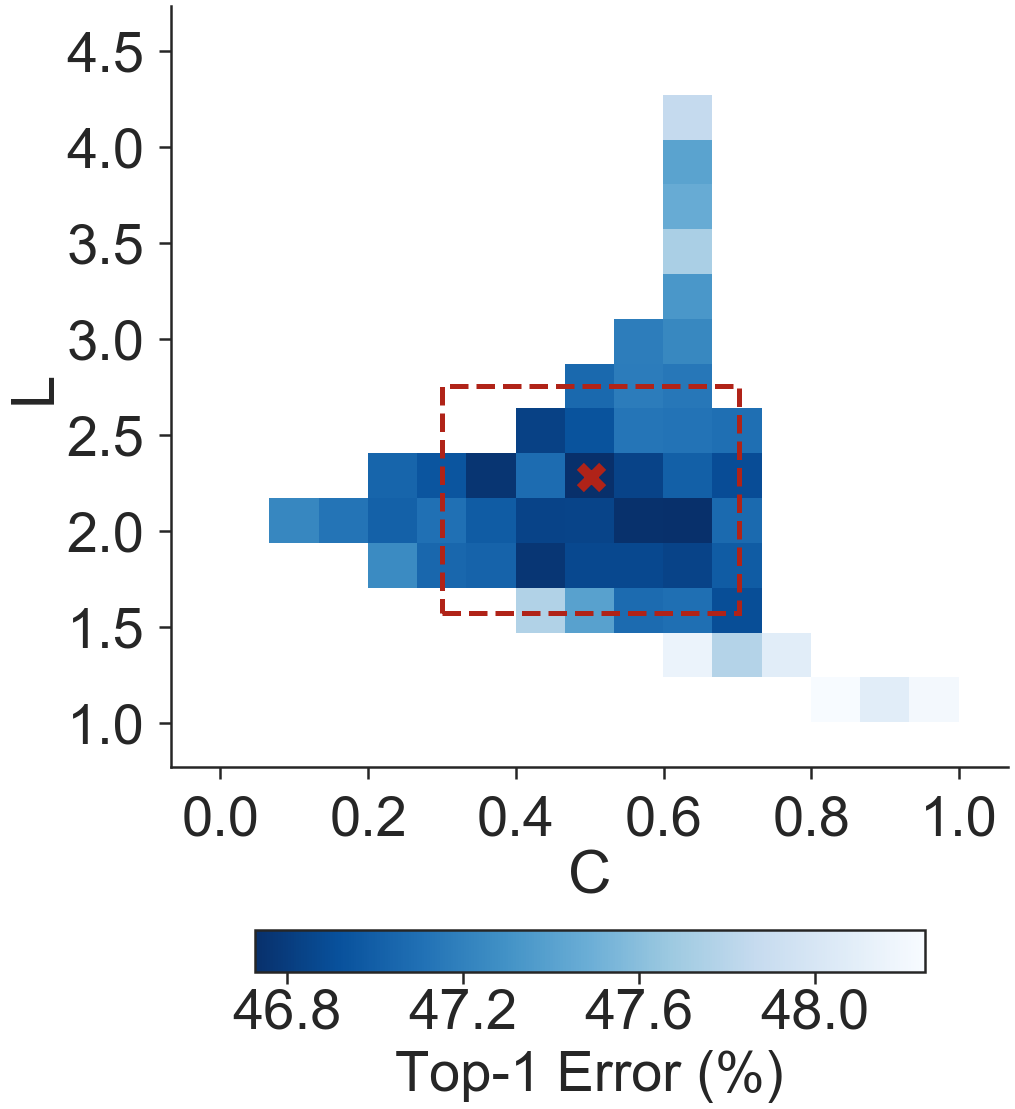

In [4]:
### Plots for CNN on ImageNet
task_name = 'cnn6_imagenet'
title_name = 'CNN-6 on ImageNet'
trainseed_num = 3
epoch = 100
baseline_transform = 'convbasic'
graph_num = 52

names_all_seed1 = np.load('final_results/{}_seed1/names_{}_seed1_epoch100.npy'.format(task_name,task_name))
results_all_seed1 = np.load('final_results/{}_seed1/results_{}_seed1_epoch100.npy'.format(task_name,task_name))
names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
names_all_seed2 = np.load('final_results/{}_seed2/names_{}_seed2_epoch100.npy'.format(task_name,task_name))
results_all_seed2 = np.load('final_results/{}_seed2/results_{}_seed2_epoch100.npy'.format(task_name,task_name))
names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
names_all_seed3 = np.load('final_results/{}_seed3/names_{}_seed3_epoch100.npy'.format(task_name,task_name))
results_all_seed3 = np.load('final_results/{}_seed3/results_{}_seed3_epoch100.npy'.format(task_name,task_name))
names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
assert np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]) and np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7])
names_all = names_all_seed1
results_all = np.concatenate((results_all_seed1,results_all_seed2,results_all_seed3),axis=1)
print(task_name, names_all.shape, results_all.shape)

result_final, sweet_spot = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, return_sweet_spot=True)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [52] if i<=graph_num]
for bin_num in bin_range:
     plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

resnet34_imagenet (53, 15) (53, 3, 8)
baseline 25.73 0.07
best 24.57 0.1
top 10
 [[24.57  0.1 ]
 [24.62  0.05]
 [24.63  0.05]
 [24.64  0.22]
 [24.66  0.08]
 [24.66  0.02]
 [24.69  0.11]
 [24.69  0.04]
 [24.69  0.09]
 [24.75  0.13]]
sweet spot clustering min 0.09765468906093913, max 0.6360735445689213
sweet spot path min 1.5803571428571428, max 2.5218253968253967


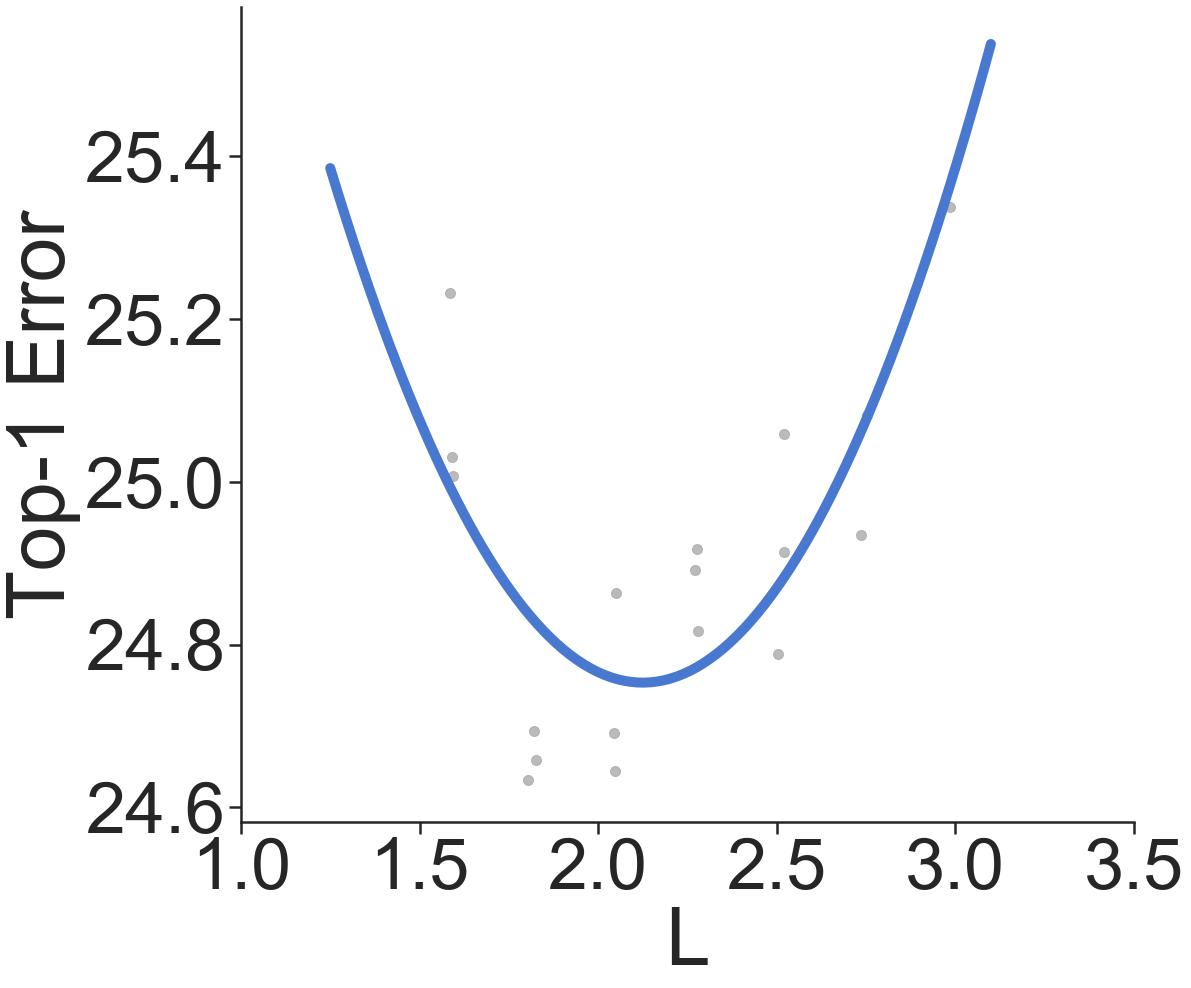

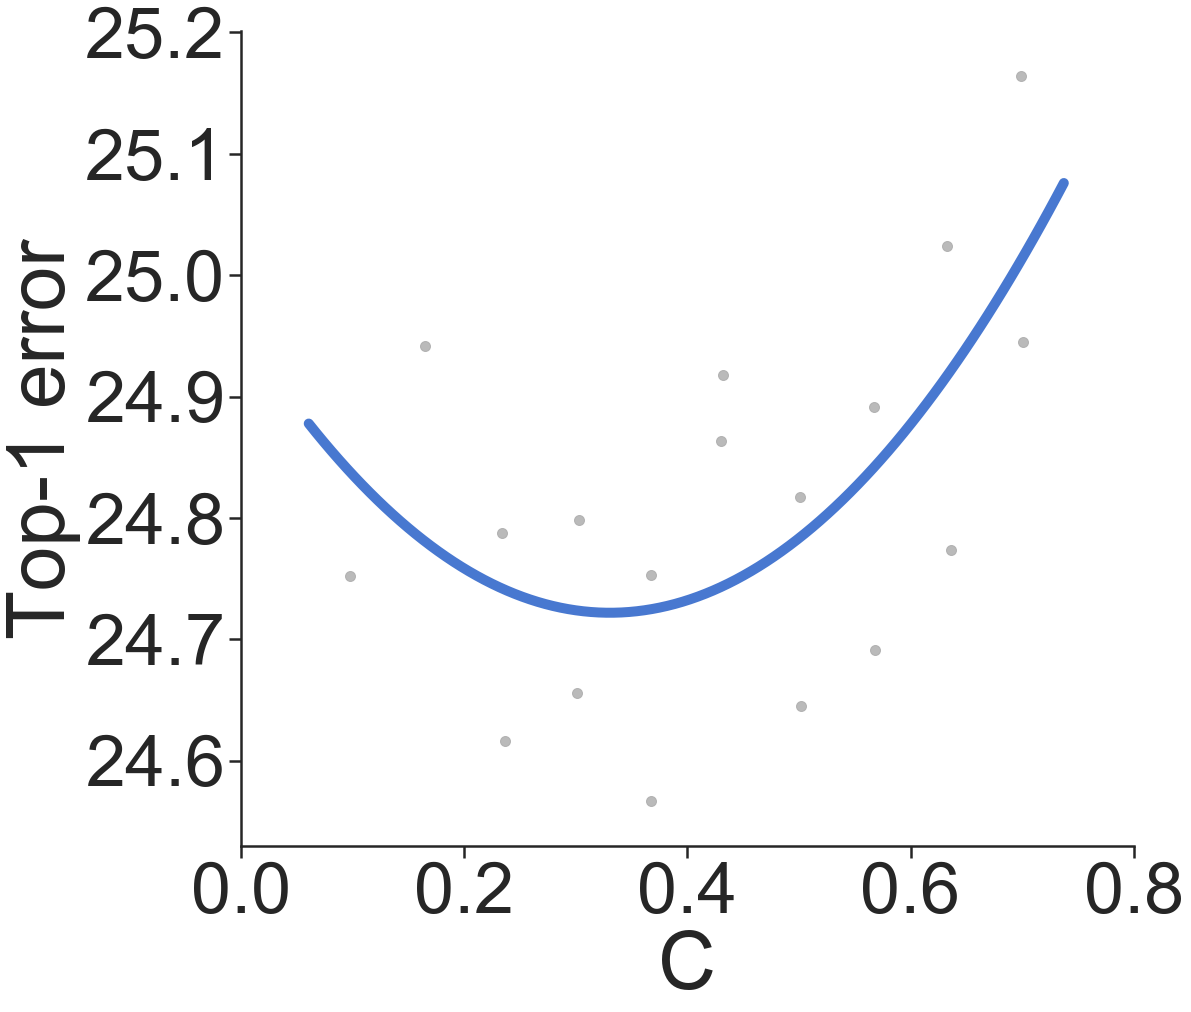

clustering 2 15 16
path 1 14 16


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in true_divide


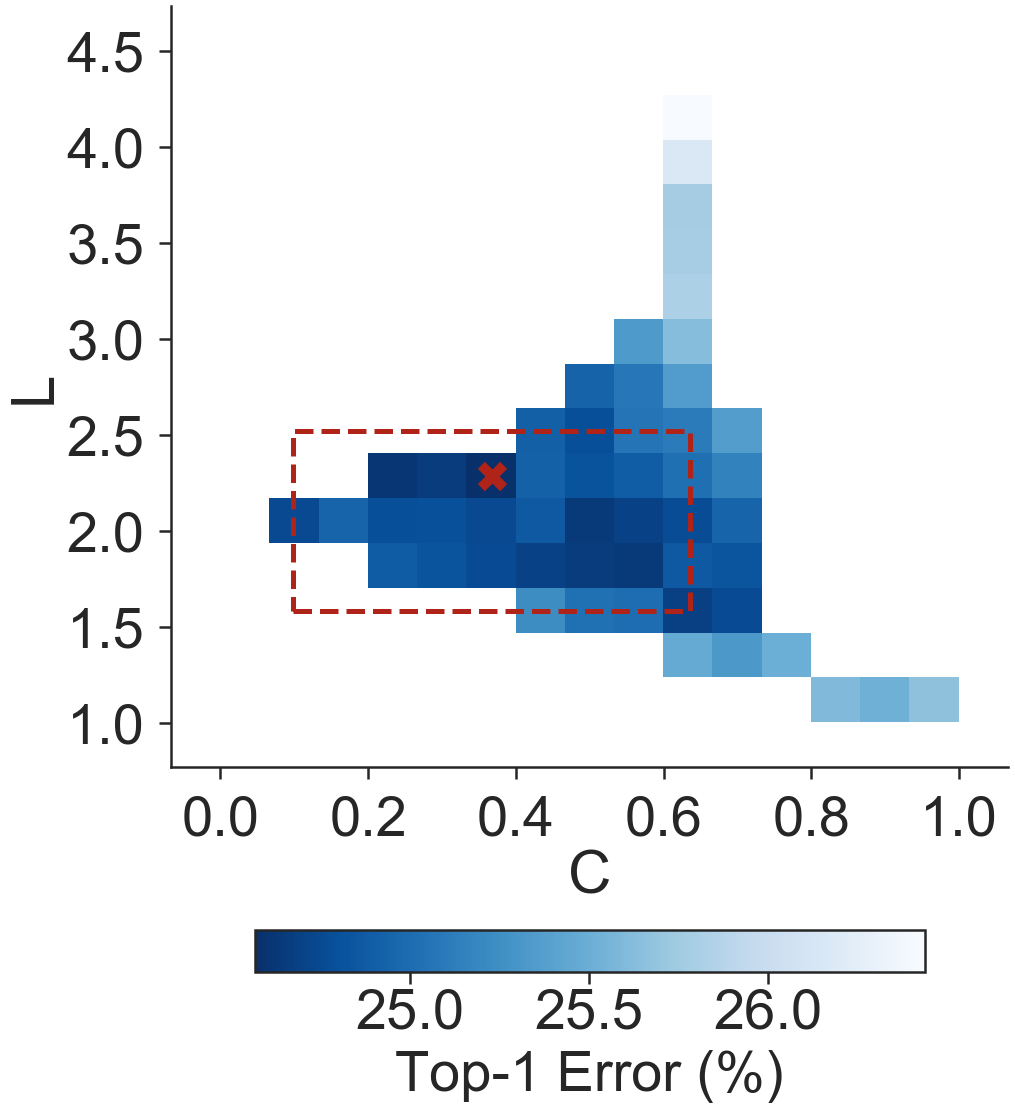

In [5]:
### Plots for ResNet34 on ImageNet
task_name = 'resnet34_imagenet'
title_name = 'ResNet-34 on ImageNet'
trainseed_num = 3
epoch = 100
baseline_transform = 'channelbasic'
graph_num = 52

names_all_seed1 = np.load('final_results/resnet34_imagenet_seed1/names_resnet34_imagenet_epoch100.npy')
results_all_seed1 = np.load('final_results/resnet34_imagenet_seed1/results_resnet34_imagenet_epoch100.npy')
names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
names_all_seed2 = np.load('final_results/resnet34_imagenet_seed2/names_resnet34_imagenet_seed2_epoch100.npy')
results_all_seed2 = np.load('final_results/resnet34_imagenet_seed2/results_resnet34_imagenet_seed2_epoch100.npy')
names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
names_all_seed3 = np.load('final_results/resnet34_imagenet_seed3/names_resnet34_imagenet_seed3_epoch100.npy')
results_all_seed3 = np.load('final_results/resnet34_imagenet_seed3/results_resnet34_imagenet_seed3_epoch100.npy')
names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
assert np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]) and np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7])
names_all = names_all_seed1
results_all = np.concatenate((results_all_seed1,results_all_seed2,results_all_seed3),axis=1)
print(task_name, names_all.shape, results_all.shape)

result_final, sweet_spot = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, return_sweet_spot=True)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [52] if i<=graph_num]
for bin_num in bin_range:
     plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

resnet34_sep_imagenet (53, 15) (53, 3, 8)
baseline 28.39 0.05
best 27.17 0.18
top 10
 [[27.17  0.18]
 [27.2   0.1 ]
 [27.21  0.07]
 [27.21  0.05]
 [27.21  0.03]
 [27.21  0.19]
 [27.25  0.11]
 [27.27  0.1 ]
 [27.28  0.02]
 [27.29  0.15]]
sweet spot clustering min 0.09765468906093913, max 0.7025487307076977
sweet spot path min 1.5719246031746033, max 2.5287698412698414


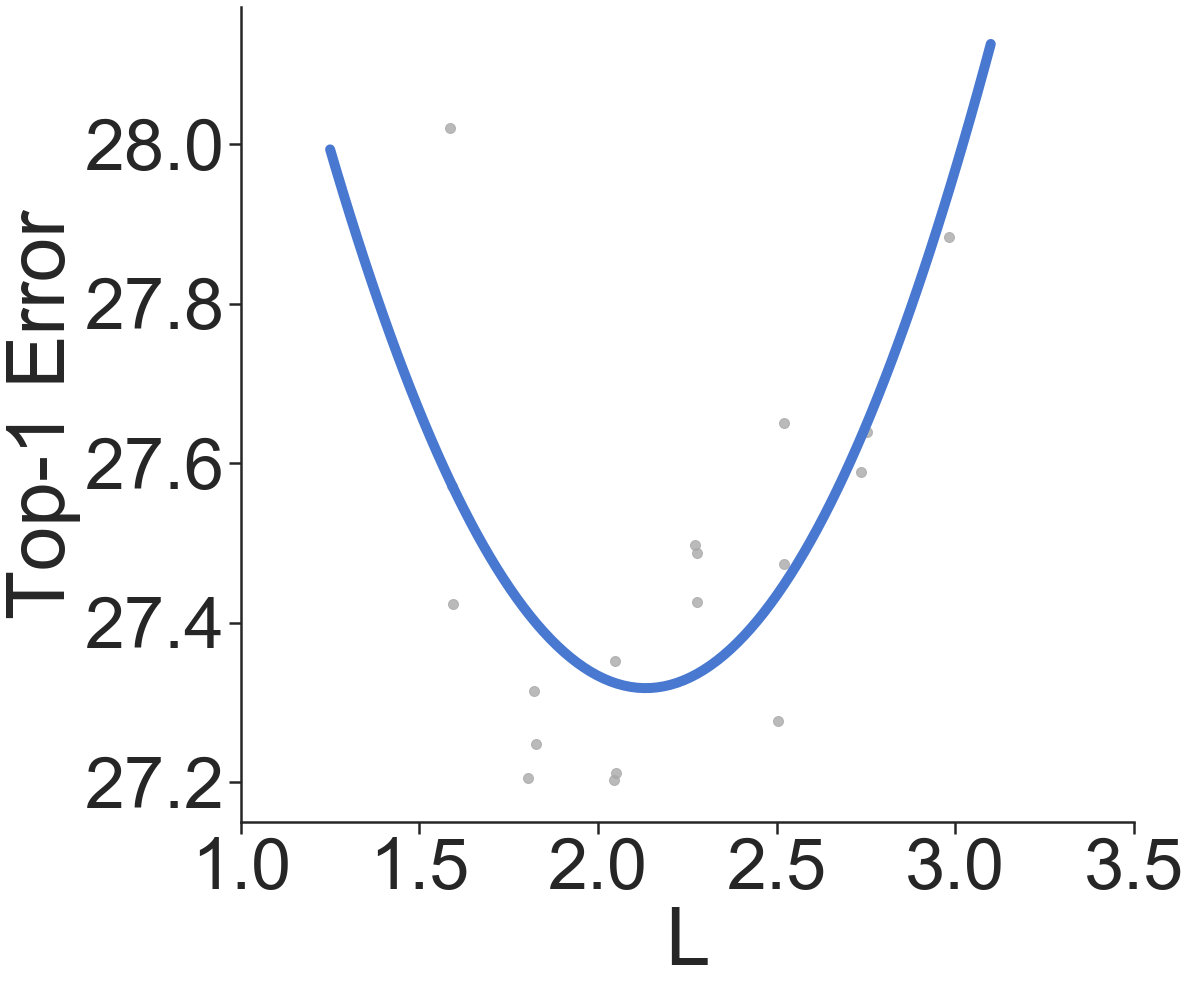

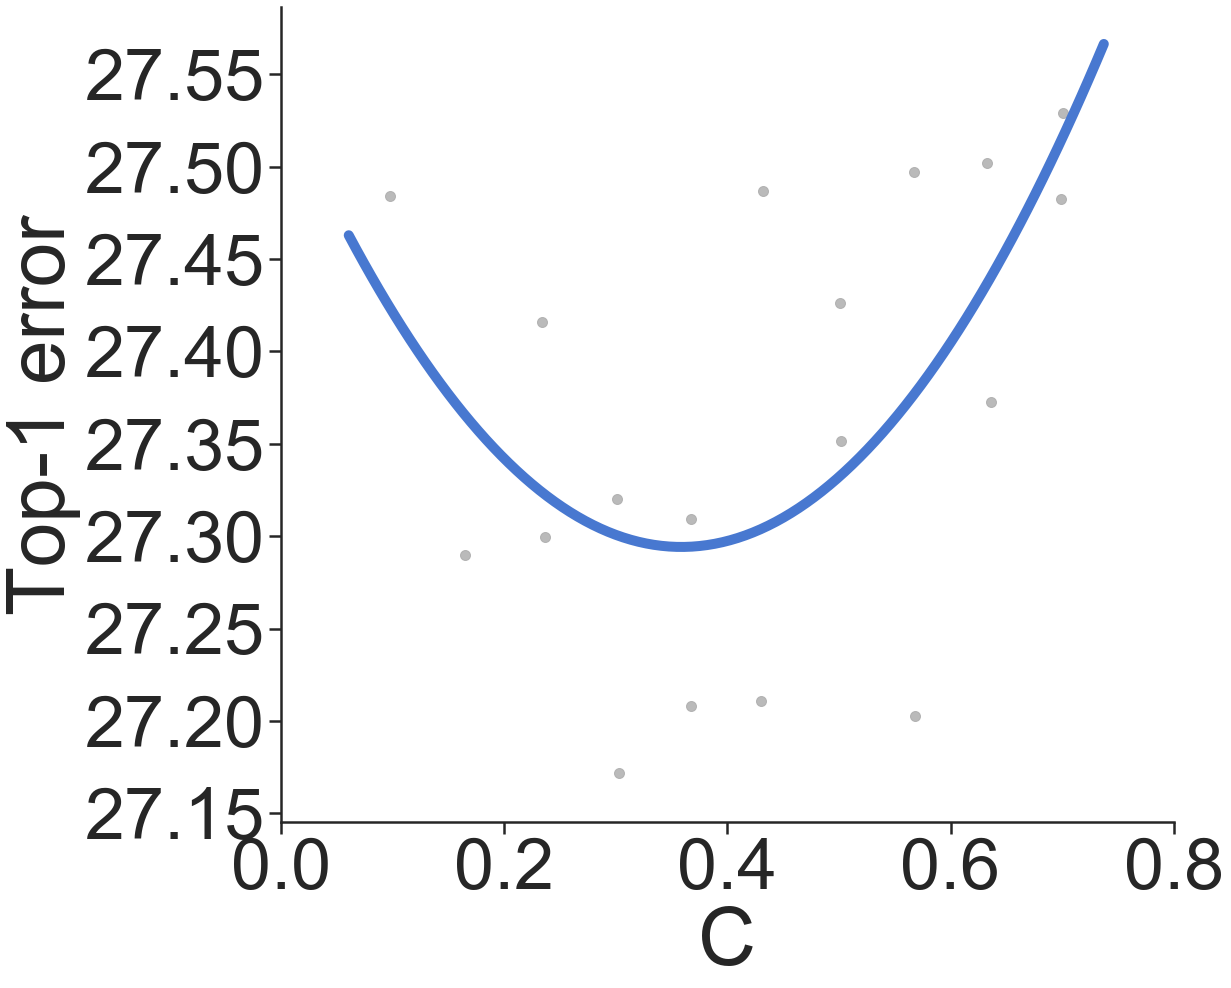

clustering 2 15 16
path 1 14 16


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in true_divide


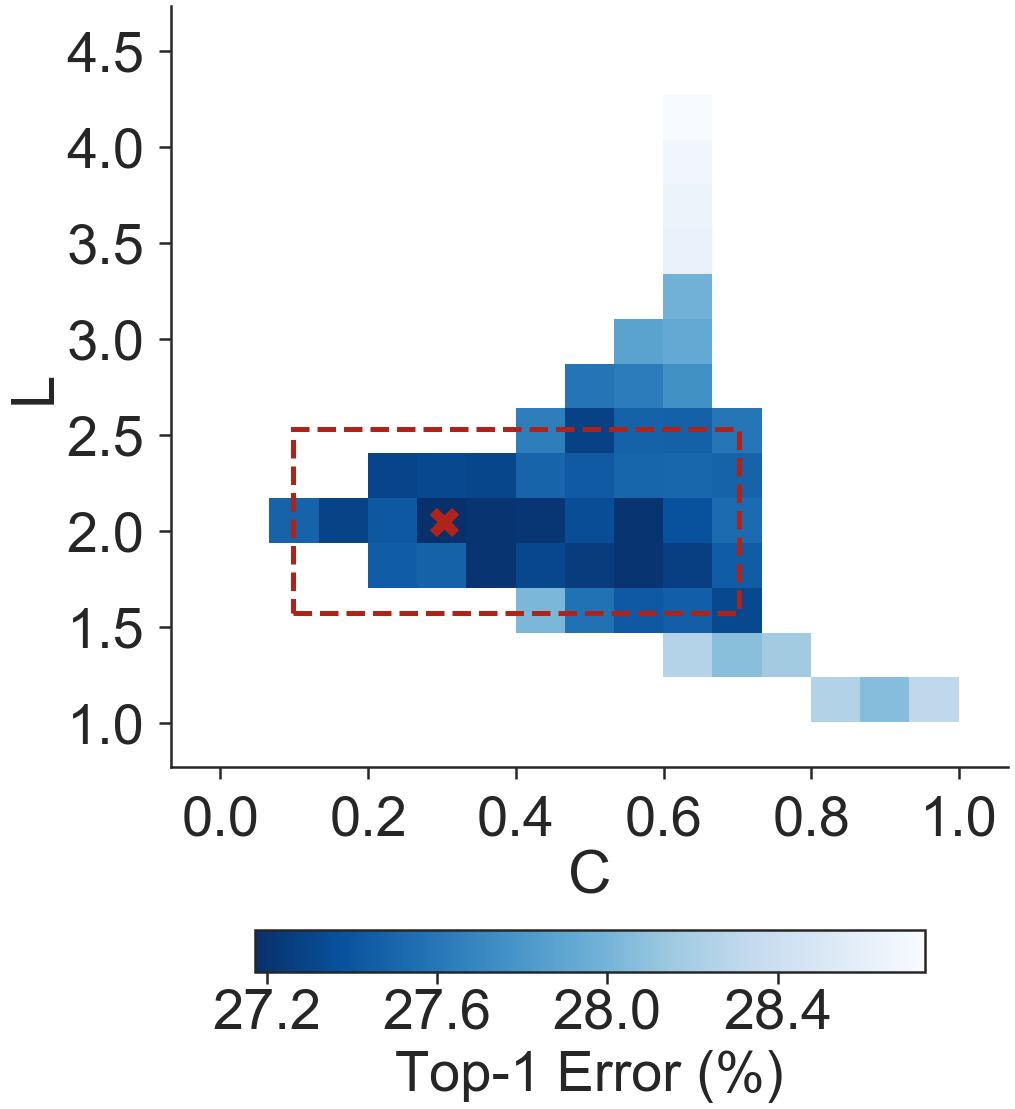

In [6]:
### Plots for ResNet34-sep on ImageNet
task_name = 'resnet34_sep_imagenet'
title_name = 'ResNet-34-sep on ImageNet'
trainseed_num = 3
epoch = 100
baseline_transform = 'channelsep'
graph_num = 52

names_all_seed1 = np.load('final_results/resnet34_sep_imagenet_seed1/names_resnet34_sep_imagenet_epoch100.npy')
results_all_seed1 = np.load('final_results/resnet34_sep_imagenet_seed1/results_resnet34_sep_imagenet_epoch100.npy')
names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
names_all_seed2 = np.load('final_results/resnet34_sep_imagenet_seed2/names_resnet34_sep_imagenet_seed2_epoch100.npy')
results_all_seed2 = np.load('final_results/resnet34_sep_imagenet_seed2/results_resnet34_sep_imagenet_seed2_epoch100.npy')
names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
# there is 1 missing data in row 37
if not np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]):
    names_all_seed2 = np.insert(names_all_seed2,37,names_all_seed1[37],axis=0)
    results_all_seed2 = np.insert(results_all_seed2,37,results_all_seed1[37],axis=0)
names_all_seed3 = np.load('final_results/resnet34_sep_imagenet_seed3/names_resnet34_sep_imagenet_seed3_epoch100.npy')
results_all_seed3 = np.load('final_results/resnet34_sep_imagenet_seed3/results_resnet34_sep_imagenet_seed3_epoch100.npy')
names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
assert np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]) and np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7])
names_all = names_all_seed1
results_all = np.concatenate((results_all_seed1,results_all_seed2,results_all_seed3),axis=1)
print(task_name, names_all.shape, results_all.shape)

result_final, sweet_spot = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, return_sweet_spot=True)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [52] if i<=graph_num]
for bin_num in bin_range:
     plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

resnet50_imagenet (53, 15) (53, 3, 8)
baseline 23.09 0.05
best 22.42 0.09
top 10
 [[22.42  0.09]
 [22.45  0.02]
 [22.46  0.04]
 [22.47  0.08]
 [22.47  0.15]
 [22.48  0.09]
 [22.5   0.19]
 [22.52  0.05]
 [22.54  0.18]
 [22.57  0.17]]
sweet spot clustering min 0.43011589105339104, max 0.7025487307076977
sweet spot path min 1.5719246031746033, max 2.2807539682539684


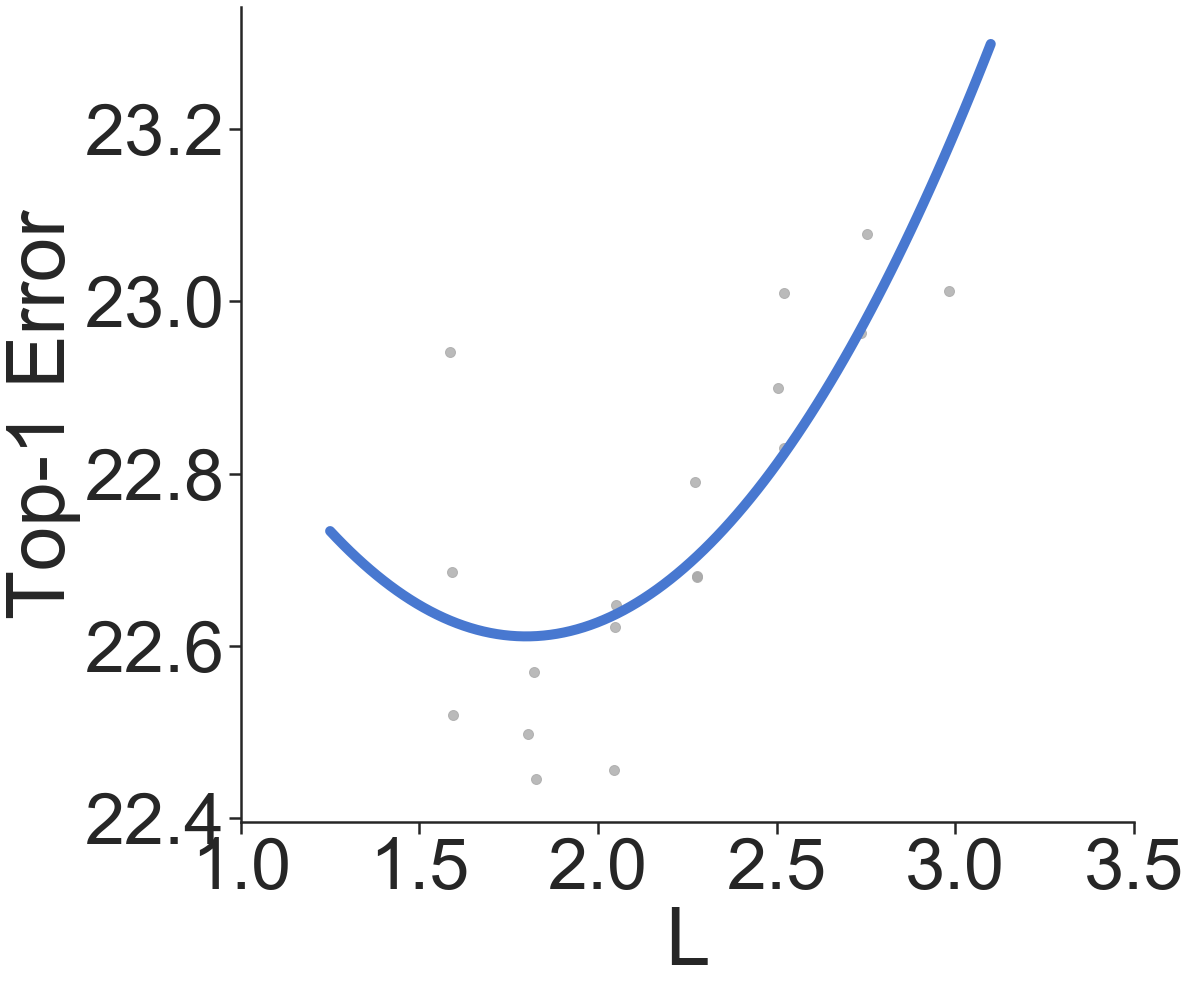

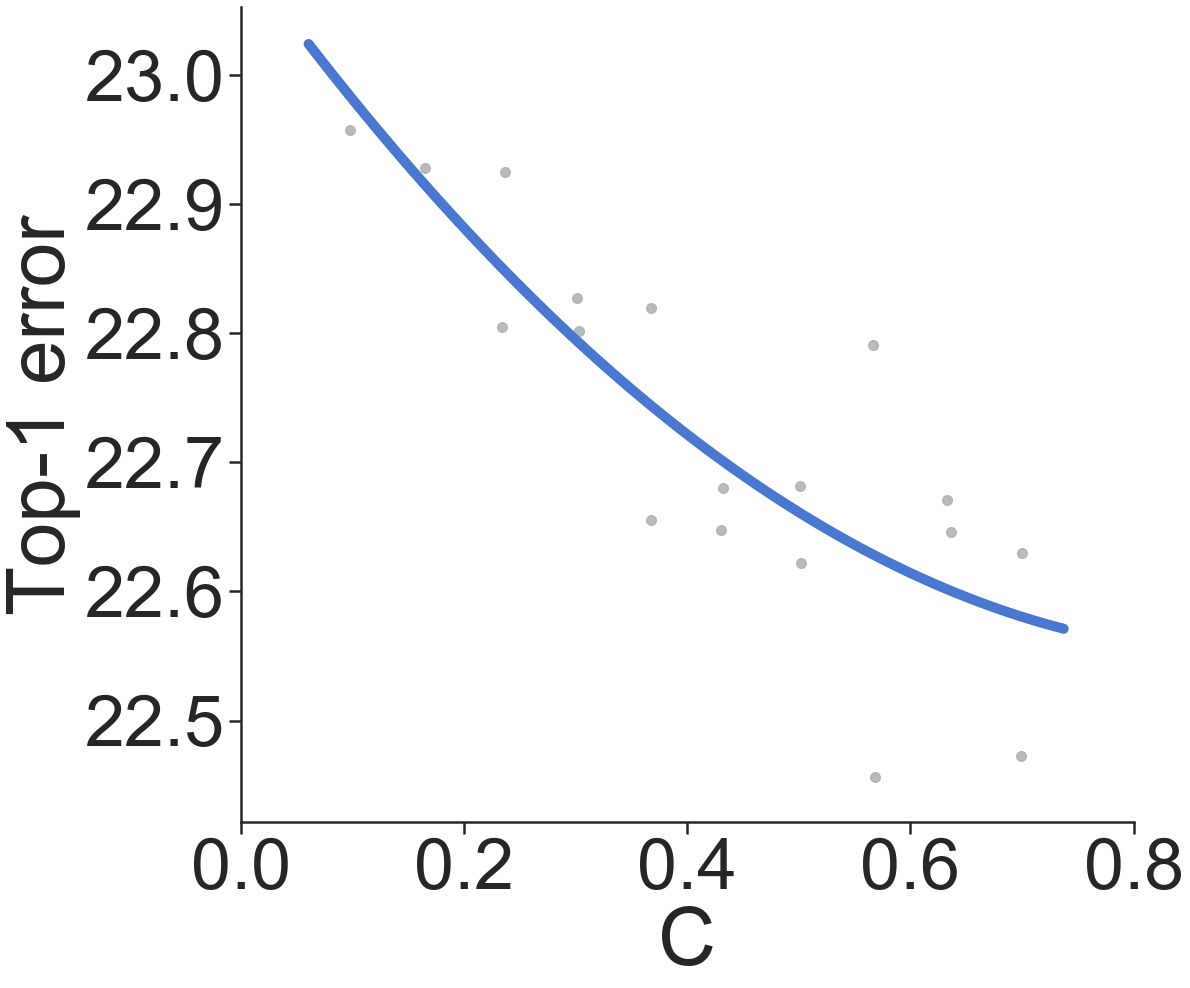

clustering 2 15 16
path 1 14 16


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:392: RuntimeWarning: invalid value encountered in true_divide


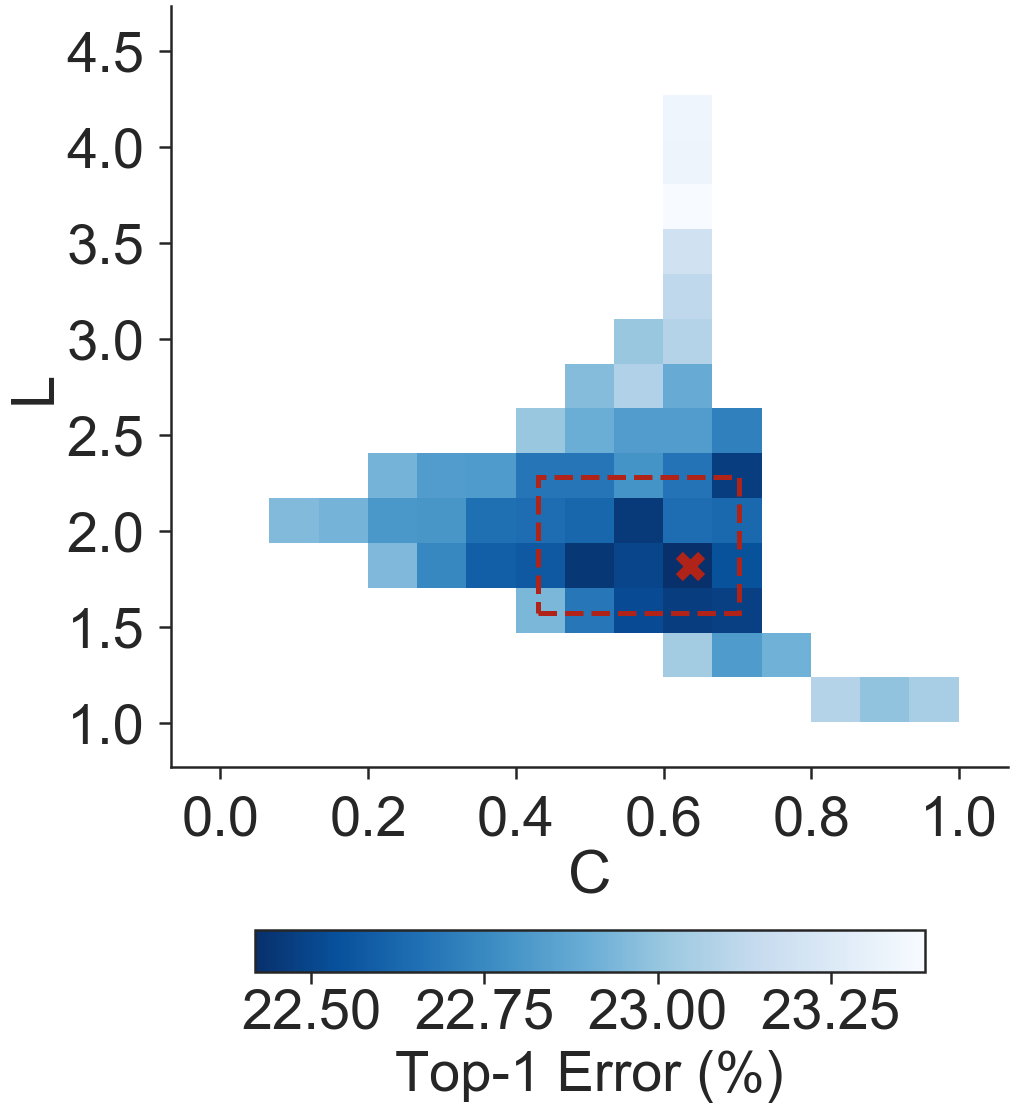

In [7]:
### Plots for ResNet50 on ImageNet
task_name = 'resnet50_imagenet'
title_name = 'ResNet-50 on ImageNet'
trainseed_num = 3
epoch = 100
baseline_transform = 'bottleneck'
graph_num = 52


names_all_seed1 = np.load('final_results/resnet50_imagenet_seed1/names_resnet50_imagenet_epoch100.npy')
results_all_seed1 = np.load('final_results/resnet50_imagenet_seed1/results_resnet50_imagenet_epoch100.npy')
names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
names_all_seed2 = np.load('final_results/resnet50_imagenet_seed2/names_resnet50_imagenet_seed2_epoch100.npy')
results_all_seed2 = np.load('final_results/resnet50_imagenet_seed2/results_resnet50_imagenet_seed2_epoch100.npy')
names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
names_all_seed3 = np.load('final_results/resnet50_imagenet_seed3/names_resnet50_imagenet_seed3_epoch100.npy')
results_all_seed3 = np.load('final_results/resnet50_imagenet_seed3/results_resnet50_imagenet_seed3_epoch100.npy')
names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
assert np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]) and np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7])
names_all = names_all_seed1
results_all = np.concatenate((results_all_seed1,results_all_seed2,results_all_seed3),axis=1)
print(task_name, names_all.shape, results_all.shape)

result_final, sweet_spot = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, return_sweet_spot=True)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [52] if i<=graph_num]
for bin_num in bin_range:
     plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

efficient_imagenet (49, 15) (49, 3, 8)
baseline 25.59 0.05
best 25.07 0.17
top 10
 [[25.07  0.17]
 [25.08  0.11]
 [25.08  0.11]
 [25.11  0.15]
 [25.14  0.24]
 [25.15  0.14]
 [25.15  0.17]
 [25.15  0.26]
 [25.16  0.07]
 [25.17  0.03]]
sweet spot clustering min 0.12291666666666666, max 0.6953647047397049
sweet spot path min 1.4083333333333334, max 2.308333333333333


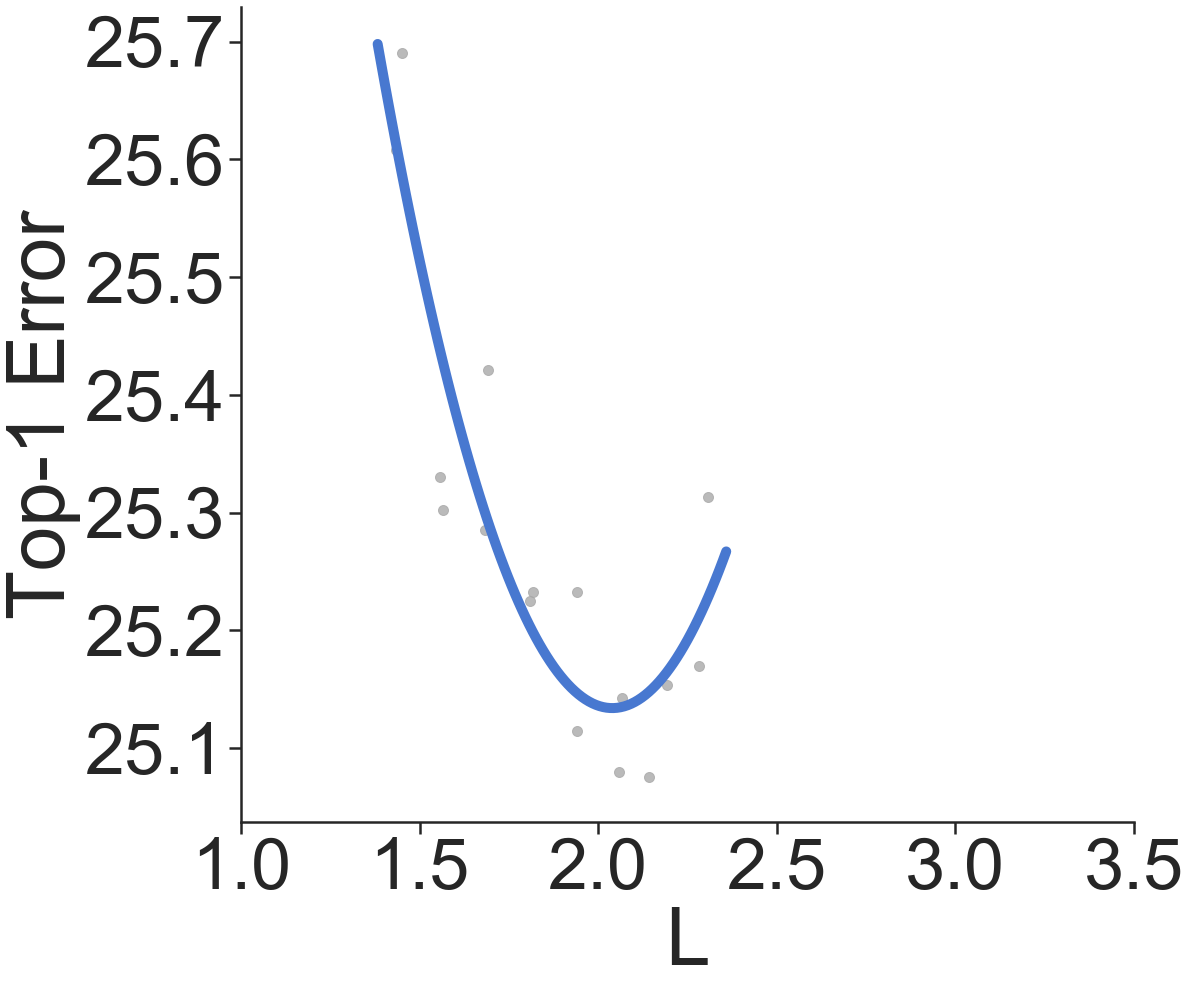

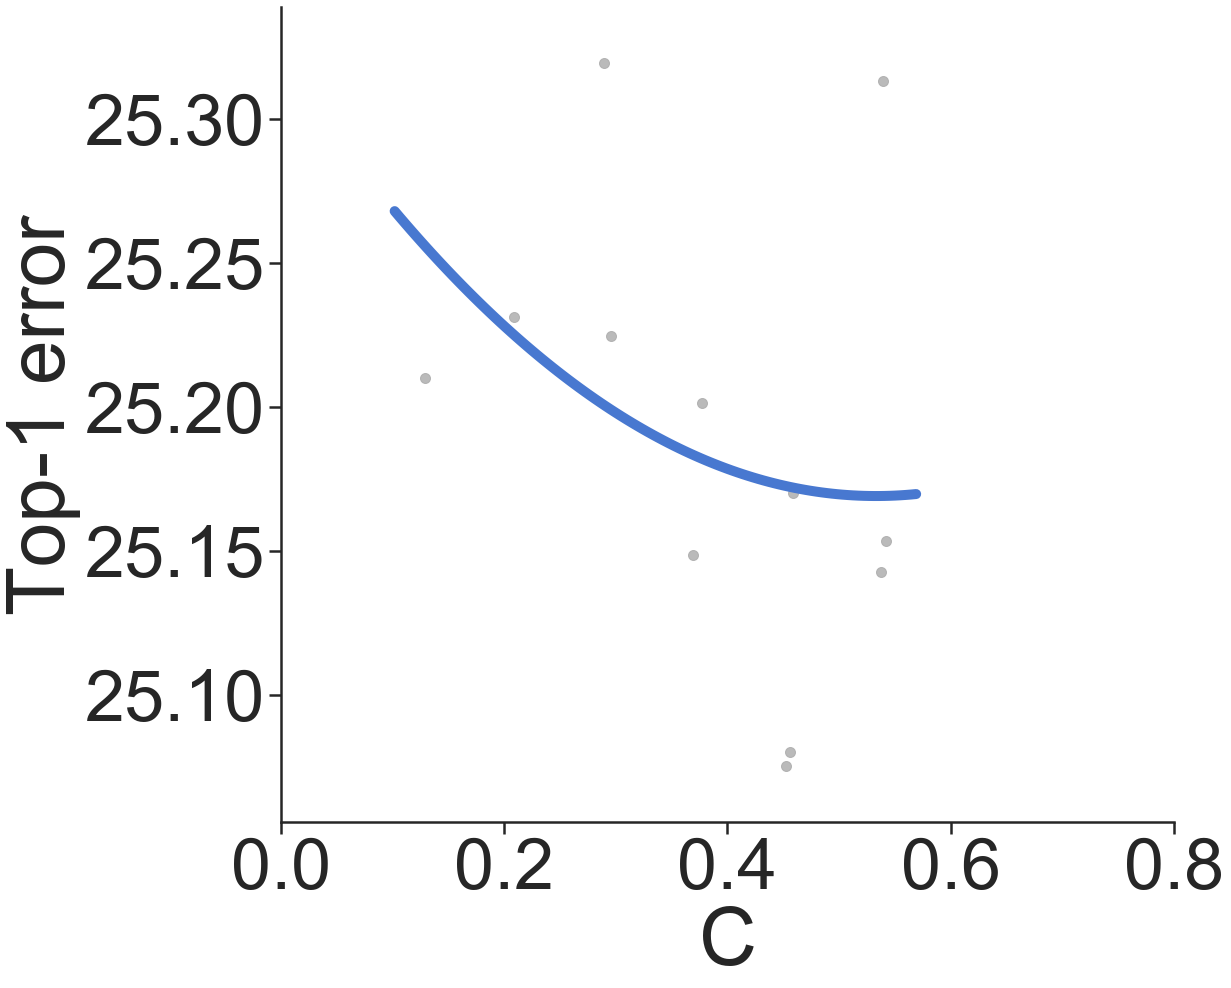

clustering 2 12 13
path 1 11 13


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:386: RuntimeWarning: invalid value encountered in true_divide


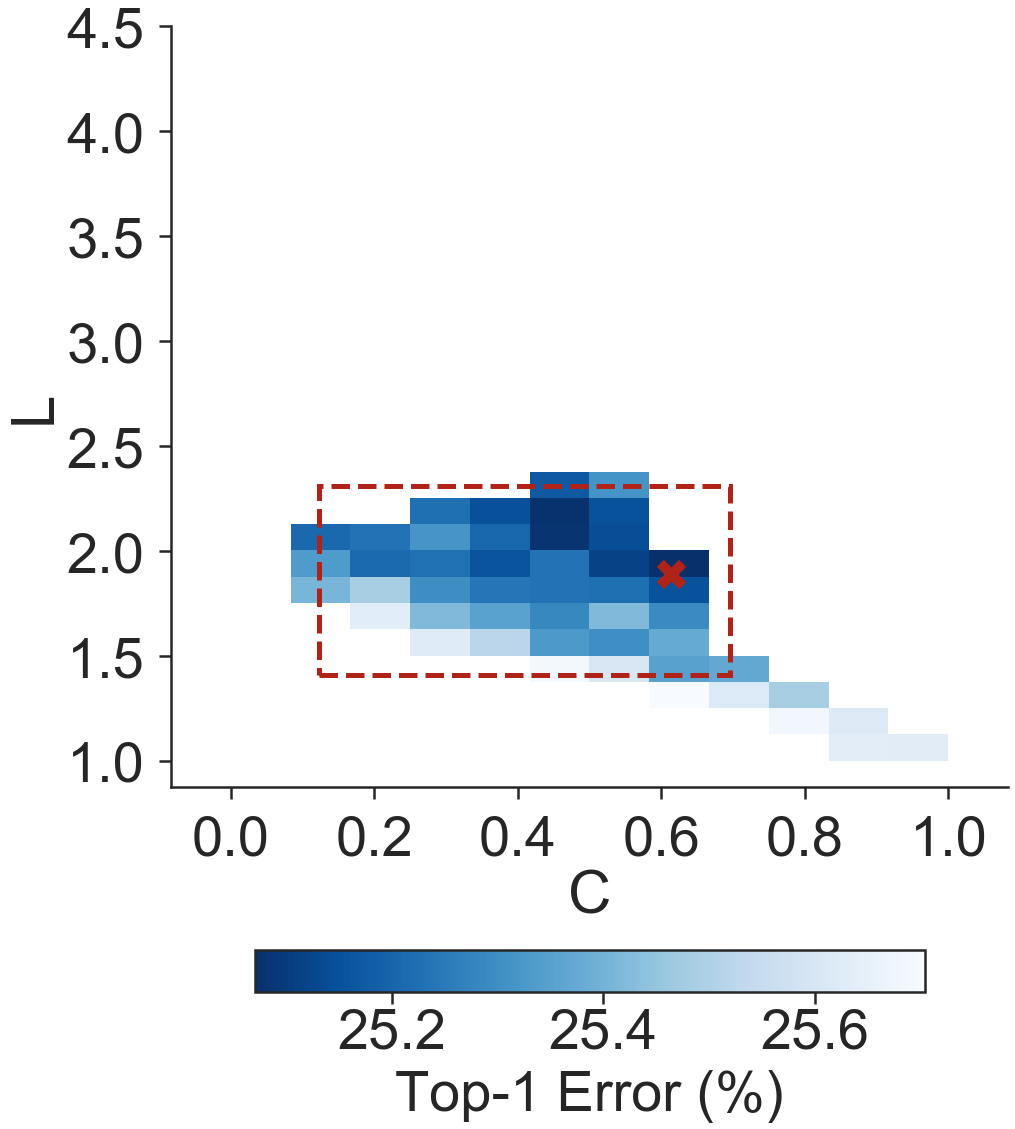

In [72]:
task_name = 'efficient_imagenet'
title_name = 'Efficientnet on ImageNet'
trainseed_num = 3
epoch = 100
baseline_transform = 'mbconv'
graph_num = 48
node_num = 16

names_all_seed1 = np.load('final_results/efficientnet_imagenet_seed1/names_efficientnet_imagenet_seed1_epoch100.npy')
results_all_seed1 = np.load('final_results/efficientnet_imagenet_seed1/results_efficientnet_imagenet_seed1_epoch100.npy')
names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
names_all_seed2 = np.load('final_results/efficientnet_imagenet_seed2/names_efficientnet_imagenet_seed2_epoch100.npy')
results_all_seed2 = np.load('final_results/efficientnet_imagenet_seed2/results_efficientnet_imagenet_seed2_epoch100.npy')
names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
names_all_seed3 = np.load('final_results/efficientnet_imagenet_seed3/names_efficientnet_imagenet_seed3_epoch100.npy')
results_all_seed3 = np.load('final_results/efficientnet_imagenet_seed3/results_efficientnet_imagenet_seed3_epoch100.npy')
names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
# there is 1 missing data in row 0
if not np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7]):
    names_all_seed3 = np.insert(names_all_seed3,9,names_all_seed1[9],axis=0)
    results_all_seed3 = np.insert(results_all_seed3,9,results_all_seed1[9],axis=0)
assert np.array_equal(names_all_seed1[:,:7], names_all_seed2[:,:7]) and np.array_equal(names_all_seed1[:,:7], names_all_seed3[:,:7])
names_all = names_all_seed1
results_all = np.concatenate((results_all_seed1,results_all_seed2,results_all_seed3),axis=1)
print(task_name, names_all.shape, results_all.shape)

result_final, sweet_spot = align_results(names_all, results_all, trainseed_num, baseline_transform, graph_num, node_num, return_sweet_spot=True)
plot_1d_slice(result_final, task_name, title_name)
bin_range = [i for i in [48] if i<=graph_num]
for bin_num in bin_range:
     plot_2d(result_final, task_name, bin_num, simple=True, sweet_spot=sweet_spot)

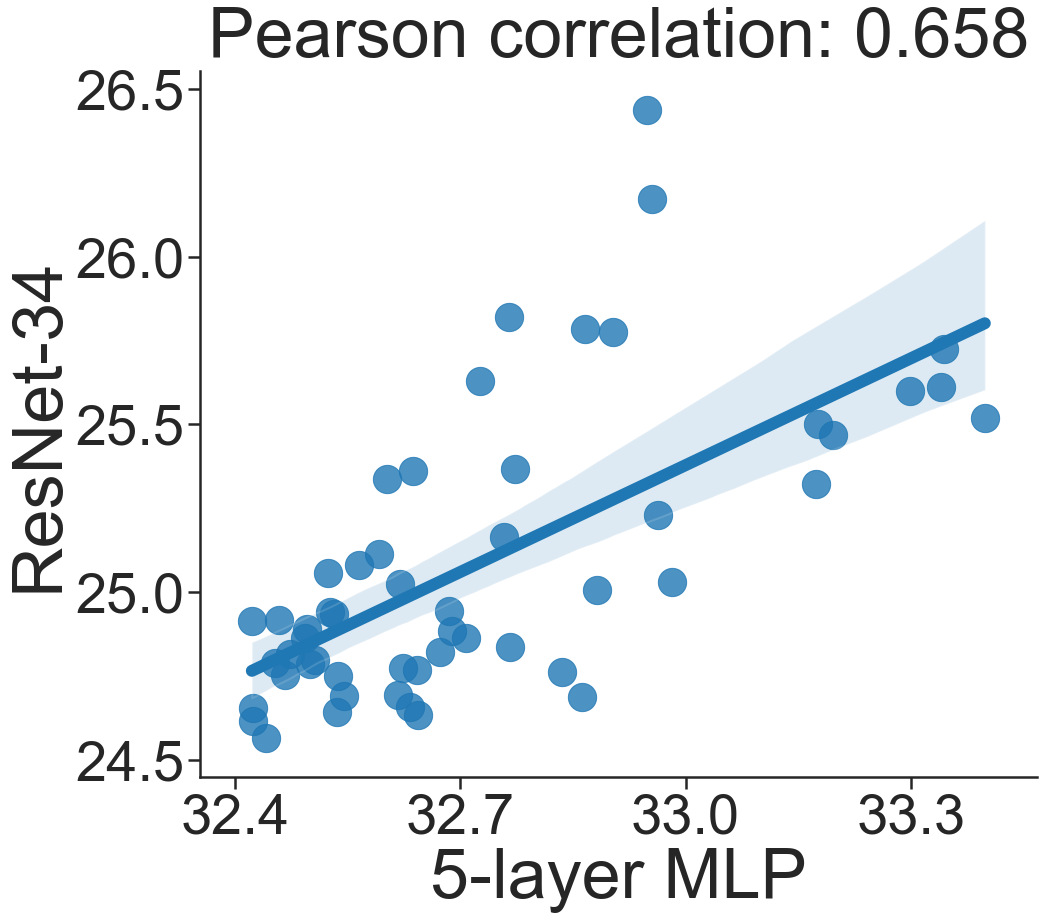

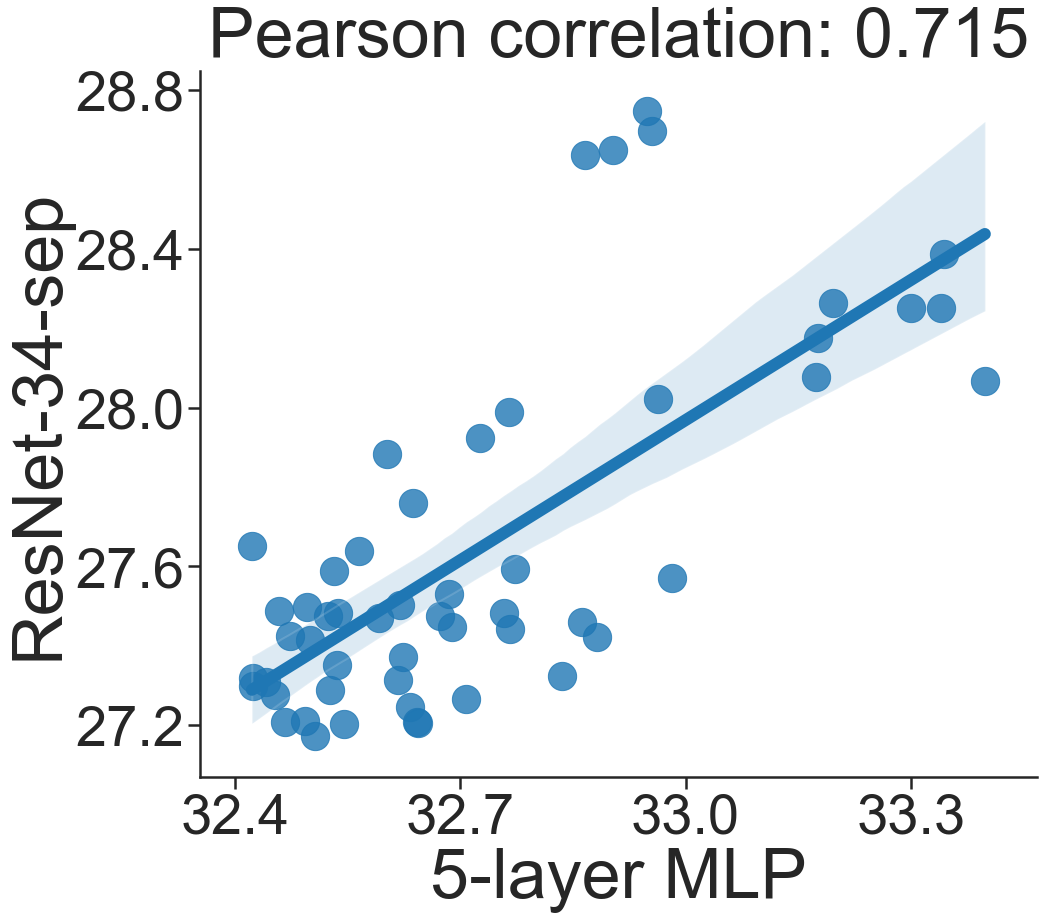

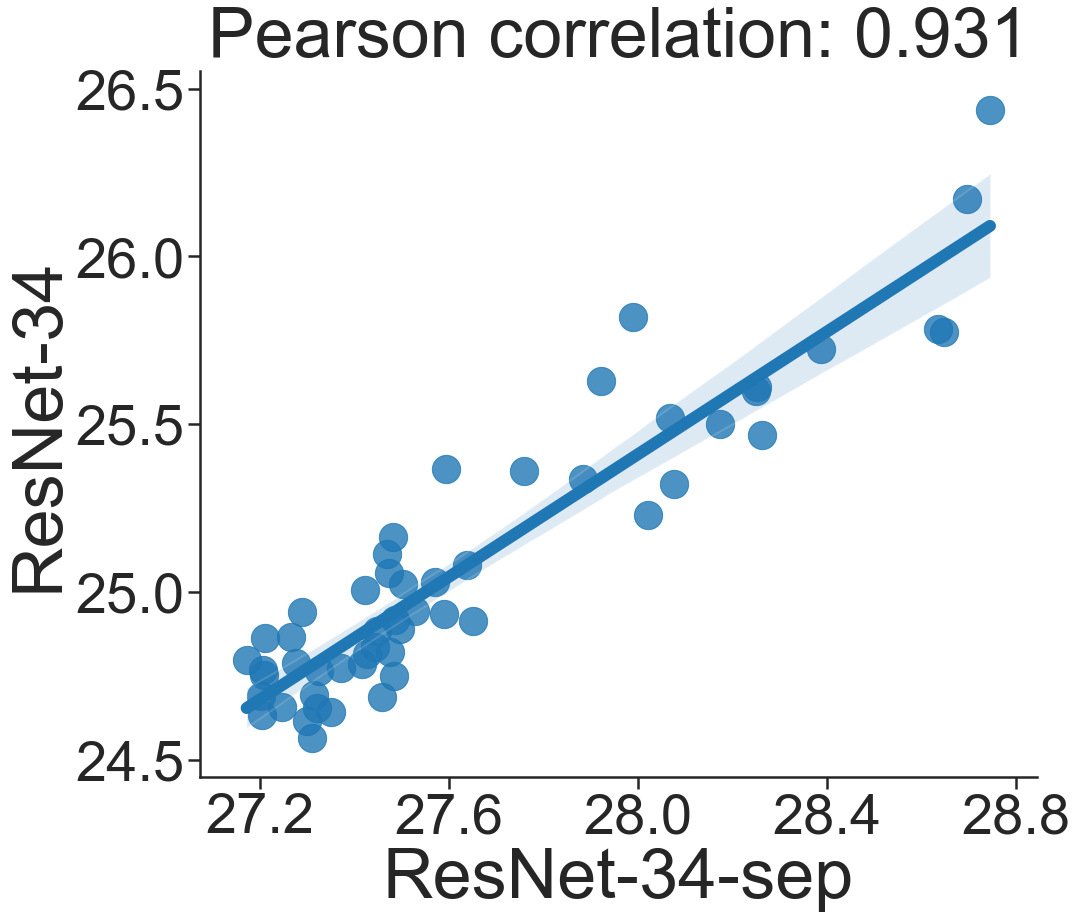

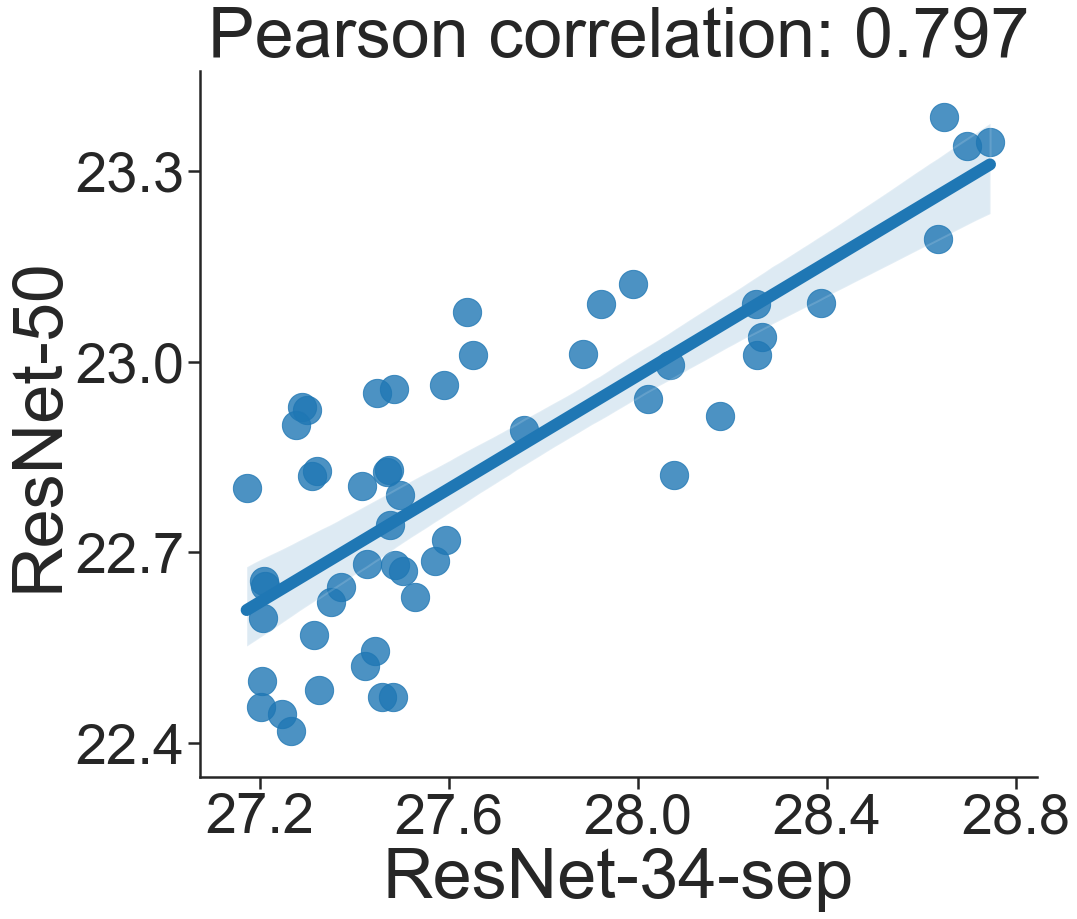

In [8]:
######### (1) Correlation over different experiment settings
result_mlp = np.load('final_results/npys/mlp_cifar10_resolution52.npy')
result_res34 = np.load('final_results/npys/resnet34_imagenet_resolution52.npy')
result_res34sep = np.load('final_results/npys/resnet34_sep_imagenet_resolution52.npy')
result_res50 = np.load('final_results/npys/resnet50_imagenet_resolution52.npy')


axis_dict = {'mlp':[32.4,32.7,33.0,33.3], 'res34':[24.5,25,25.5,26,26.5], 
             'res34sep':[27.2,27.6,28.0,28.4,28.8], 'res50':[22.4,22.7,23.0,23.3]}

point_size = 800
line_width = 12
def corr_plot(a, b, a_name, b_name, a_axisname, b_axisname):
    fig = plt.figure(figsize=(15,13))
    sns.set_style("ticks")
    sns.color_palette('muted')
    ax = fig.gca()    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    sns.regplot(a,b, scatter_kws={'s':point_size}, line_kws={'linewidth':line_width})

    plt.xlabel(a_axisname, fontsize=70)
    plt.ylabel(b_axisname, fontsize=70)
    plt.title('Pearson correlation: {}'.format(round(sp.stats.pearsonr(a,b)[0],3)), fontsize=70)
    plt.xticks(axis_dict[a_name], fontsize=56)
    plt.yticks(axis_dict[b_name],fontsize=56)
    plt.savefig('final_results/figs/corr_{}_{}.png'.format(a_name, b_name),dpi=100,bbox_inches='tight')
    plt.show()

corr_plot(result_mlp,result_res34,'mlp','res34','5-layer MLP', 'ResNet-34')
corr_plot(result_mlp,result_res34sep,'mlp','res34sep','5-layer MLP', 'ResNet-34-sep')
corr_plot(result_res34sep,result_res34,'res34sep','res34','ResNet-34-sep', 'ResNet-34')
corr_plot(result_res34sep,result_res50,'res34sep','res50','ResNet-34-sep', 'ResNet-50')


In [2]:
######### (2) Correlation over different epochs

task_name = 'resnet34_imagenet'
title_name = 'ResNet34 on ImageNet'
trainseed_num = 1
baseline_transform = 'channelbasic'
graph_num = 52

result_final_list_1 = []
result_final_list_2 = []
result_final_list_3 = []
for epoch in range(1,101):
    names_all_seed1 = np.load('final_results/resnet34_imagenet_seed1/names_resnet34_imagenet_epoch{}.npy'.format(epoch))
    results_all_seed1 = np.load('final_results/resnet34_imagenet_seed1/results_resnet34_imagenet_epoch{}.npy'.format(epoch))
    names_all_seed1, results_all_seed1 = sort_results(names_all_seed1, results_all_seed1)
    result_final = align_results(names_all_seed1, results_all_seed1, trainseed_num, baseline_transform, graph_num)
    result_final_list_1.append(result_final)
    
    
    names_all_seed2 = np.load('final_results/resnet34_imagenet_seed2/names_resnet34_imagenet_seed2_epoch{}.npy'.format(epoch))
    results_all_seed2 = np.load('final_results/resnet34_imagenet_seed2/results_resnet34_imagenet_seed2_epoch{}.npy'.format(epoch))
    names_all_seed2, results_all_seed2 = sort_results(names_all_seed2, results_all_seed2)
    result_final = align_results(names_all_seed2, results_all_seed2, trainseed_num, baseline_transform, graph_num)
    result_final_list_2.append(result_final)
    
    names_all_seed3 = np.load('final_results/resnet34_imagenet_seed3/names_resnet34_imagenet_seed3_epoch{}.npy'.format(epoch))
    results_all_seed3 = np.load('final_results/resnet34_imagenet_seed3/results_resnet34_imagenet_seed3_epoch{}.npy'.format(epoch))
    names_all_seed3, results_all_seed3 = sort_results(names_all_seed3, results_all_seed3)
    result_final = align_results(names_all_seed3, results_all_seed3, trainseed_num, baseline_transform, graph_num)
    result_final_list_3.append(result_final)

result_final_list = []
for i in range(100):
    result_final_list.append((result_final_list_1[i]+result_final_list_2[i]+result_final_list_3[i])/3)    
    
baseline = result_final_list[99][:,-2]
corr_all = []
for i in range(100):
    current = result_final_list[i][:,-2]
    corr_all.append(sp.stats.pearsonr(current,baseline)[0])
range_all = list(range(1,101))



baseline 74.47 1.0
best 72.62 1.0
top 10
 [[72.62  1.  ]
 [72.85  1.  ]
 [73.1   1.  ]
 [73.1   1.  ]
 [73.18  1.  ]
 [73.25  1.  ]
 [73.27  1.  ]
 [73.36  1.  ]
 [73.55  1.  ]
 [73.57  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 74.14 1.0
best 72.77 1.0
top 10
 [[72.77  1.  ]
 [73.03  1.  ]
 [73.04  1.  ]
 [73.12  1.  ]
 [73.18  1.  ]
 [73.19  1.  ]
 [73.26  1.  ]
 [73.27  1.  ]
 [73.32  1.  ]
 [73.43  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 74.26 1.0
best 73.08 1.0
top 10
 [[73.08  1.  ]
 [73.13  1.  ]
 [73.18  1.  ]
 [73.24  1.  ]
 [73.29  1.  ]
 [73.29  1.  ]
 [73.38  1.  ]
 [73.42  1.  ]
 [73.59  1.  ]
 [73.6   1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 62.05 1.0
bes

/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 52.74 1.0
best 50.4 1.0
top 10
 [[50.4   1.  ]
 [50.55  1.  ]
 [50.56  1.  ]
 [50.59  1.  ]
 [50.64  1.  ]
 [50.78  1.  ]
 [50.81  1.  ]
 [50.81  1.  ]
 [50.91  1.  ]
 [50.93  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 51.06 1.0
best 48.29 1.0
top 10
 [[48.29  1.  ]
 [48.39  1.  ]
 [48.42  1.  ]
 [48.66  1.  ]
 [48.72  1.  ]
 [48.8   1.  ]
 [48.89  1.  ]
 [48.89  1.  ]
 [48.9   1.  ]
 [48.92  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 50.89 1.0
best 48.46 1.0
top 10
 [[48.46  1.  ]
 [48.47  1.  ]
 [48.57  1.  ]
 [48.59  1.  ]
 [48.66  1.  ]
 [48.69  1.  ]
 [48.72  1.  ]
 [48.75  1.  ]
 [48.76  1.  ]
 [48.9   1.  ]]
sweet spot clustering m

baseline 46.23 1.0
best 43.14 1.0
top 10
 [[43.14  1.  ]
 [43.22  1.  ]
 [43.52  1.  ]
 [43.55  1.  ]
 [43.71  1.  ]
 [43.79  1.  ]
 [43.81  1.  ]
 [43.81  1.  ]
 [43.83  1.  ]
 [43.84  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 46.3 1.0
best 43.38 1.0
top 10
 [[43.38  1.  ]
 [43.51  1.  ]
 [43.56  1.  ]
 [43.59  1.  ]
 [43.6   1.  ]
 [43.61  1.  ]
 [43.72  1.  ]
 [43.76  1.  ]
 [43.77  1.  ]
 [43.81  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 45.92 1.0
best 42.79 1.0
top 10
 [[42.79  1.  ]
 [42.88  1.  ]
 [42.97  1.  ]
 [43.04  1.  ]
 [43.07  1.  ]
 [43.07  1.  ]
 [43.07  1.  ]
 [43.09  1.  ]
 [43.1   1.  ]
 [43.13  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 45.32 1.0
best

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 43.06 1.0
best 40.56 1.0
top 10
 [[40.56  1.  ]
 [40.69  1.  ]
 [40.8   1.  ]
 [40.81  1.  ]
 [40.82  1.  ]
 [40.88  1.  ]
 [40.9   1.  ]
 [40.97  1.  ]
 [41.01  1.  ]
 [41.04  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 43.52 1.0
best 40.67 1.0
top 10
 [[40.67  1.  ]
 [40.67  1.  ]
 [40.69  1.  ]
 [40.72  1.  ]
 [40.74  1.  ]
 [40.85  1.  ]
 [40.89  1.  ]
 [40.98  1.  ]
 [41.08  1.  ]
 [41.19  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 43.52 1.0
best 40.58 1.0
top 10
 [[40.58  1.  ]
 [40.66  1.  ]
 [40.67  1.  ]
 [40.71  1.  ]
 [40.73  1.  ]
 [40.76  1.  ]
 [40.8   1.  ]
 [40.82  1.  ]
 [40.84  1.  ]
 [40.91  1.  ]]
sweet spot clustering 

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 41.29 1.0
best 38.61 1.0
top 10
 [[38.61  1.  ]
 [38.73  1.  ]
 [38.74  1.  ]
 [38.81  1.  ]
 [38.82  1.  ]
 [38.88  1.  ]
 [38.99  1.  ]
 [39.05  1.  ]
 [39.08  1.  ]
 [39.1   1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 41.43 1.0
best 38.56 1.0
top 10
 [[38.56  1.  ]
 [38.82  1.  ]
 [38.85  1.  ]
 [38.96  1.  ]
 [38.98  1.  ]
 [38.99  1.  ]
 [39.01  1.  ]
 [39.06  1.  ]
 [39.09  1.  ]
 [39.1   1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 41.7 1.0
best 38.66 1.0
top 10
 [[38.66  1.  ]
 [38.74  1.  ]
 [38.78  1.  ]
 [38.8   1.  ]
 [38.8   1.  ]
 [38.88  1.  ]
 [38.89  1.  ]
 [38.94  1.  ]
 [38.95  1.  ]
 [39.08  1.  ]]
sweet spot clustering m

baseline 40.33 1.0
best 37.45 1.0
top 10
 [[37.45  1.  ]
 [37.48  1.  ]
 [37.52  1.  ]
 [37.54  1.  ]
 [37.69  1.  ]
 [37.7   1.  ]
 [37.71  1.  ]
 [37.74  1.  ]
 [37.81  1.  ]
 [37.87  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 40.2 1.0
best 37.51 1.0
top 10
 [[37.51  1.  ]
 [37.51  1.  ]
 [37.56  1.  ]
 [37.68  1.  ]
 [37.7   1.  ]
 [37.72  1.  ]
 [37.88  1.  ]
 [37.92  1.  ]
 [37.94  1.  ]
 [37.98  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 40.33 1.0
best 37.27 1.0
top 10
 [[37.27  1.  ]
 [37.41  1.  ]
 [37.41  1.  ]
 [37.41  1.  ]
 [37.45  1.  ]
 [37.47  1.  ]
 [37.48  1.  ]
 [37.5   1.  ]
 [37.56  1.  ]
 [37.57  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 39.89 1.0
best

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 37.05 1.0
best 34.54 1.0
top 10
 [[34.54  1.  ]
 [34.55  1.  ]
 [34.62  1.  ]
 [34.63  1.  ]
 [34.64  1.  ]
 [34.64  1.  ]
 [34.68  1.  ]
 [34.79  1.  ]
 [34.81  1.  ]
 [34.81  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 37.15 1.0
best 34.6 1.0
top 10
 [[34.6   1.  ]
 [34.67  1.  ]
 [34.67  1.  ]
 [34.73  1.  ]
 [34.75  1.  ]
 [34.8   1.  ]
 [34.86  1.  ]
 [34.89  1.  ]
 [34.95  1.  ]
 [34.96  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 37.09 1.0
best 34.64 1.0
top 10
 [[34.64  1.  ]
 [34.72  1.  ]
 [34.72  1.  ]
 [34.77  1.  ]
 [34.81  1.  ]
 [34.84  1.  ]
 [34.85  1.  ]
 [34.88  1.  ]
 [34.89  1.  ]
 [34.89  1.  ]]
sweet spot clustering m

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 33.8 1.0
best 31.38 1.0
top 10
 [[31.38  1.  ]
 [31.53  1.  ]
 [31.6   1.  ]
 [31.63  1.  ]
 [31.65  1.  ]
 [31.66  1.  ]
 [31.67  1.  ]
 [31.77  1.  ]
 [31.77  1.  ]
 [31.78  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 33.95 1.0
best 31.42 1.0
top 10
 [[31.42  1.  ]
 [31.54  1.  ]
 [31.6   1.  ]
 [31.7   1.  ]
 [31.75  1.  ]
 [31.76  1.  ]
 [31.78  1.  ]
 [31.78  1.  ]
 [31.79  1.  ]
 [31.8   1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 33.82 1.0
best 31.43 1.0
top 10
 [[31.43  1.  ]
 [31.56  1.  ]
 [31.6   1.  ]
 [31.62  1.  ]
 [31.63  1.  ]
 [31.63  1.  ]
 [31.64  1.  ]
 [31.67  1.  ]
 [31.7   1.  ]
 [31.76  1.  ]]
sweet spot clustering m

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 30.61 1.0
best 28.5 1.0
top 10
 [[28.5   1.  ]
 [28.5   1.  ]
 [28.51  1.  ]
 [28.57  1.  ]
 [28.57  1.  ]
 [28.57  1.  ]
 [28.58  1.  ]
 [28.59  1.  ]
 [28.6   1.  ]
 [28.63  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 29.91 1.0
best 28.16 1.0
top 10
 [[28.16  1.  ]
 [28.19  1.  ]
 [28.19  1.  ]
 [28.25  1.  ]
 [28.25  1.  ]
 [28.27  1.  ]
 [28.33  1.  ]
 [28.34  1.  ]
 [28.37  1.  ]
 [28.41  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 30.25 1.0
best 28.05 1.0
top 10
 [[28.05  1.  ]
 [28.06  1.  ]
 [28.28  1.  ]
 [28.3   1.  ]
 [28.34  1.  ]
 [28.39  1.  ]
 [28.41  1.  ]
 [28.43  1.  ]
 [28.43  1.  ]
 [28.45  1.  ]]
sweet spot clustering m

sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 26.53 1.0
best 25.11 1.0
top 10
 [[25.11  1.  ]
 [25.18  1.  ]
 [25.29  1.  ]
 [25.31  1.  ]
 [25.36  1.  ]
 [25.42  1.  ]
 [25.43  1.  ]
 [25.43  1.  ]
 [25.45  1.  ]
 [25.47  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 26.48 1.0
best 25.02 1.0
top 10
 [[25.02  1.  ]
 [25.02  1.  ]
 [25.05  1.  ]
 [25.08  1.  ]
 [25.11  1.  ]
 [25.15  1.  ]
 [25.16  1.  ]
 [25.16  1.  ]
 [25.21  1.  ]
 [25.26  1.  ]]
sweet spot clustering min 0.09765468906093913, max 0.9587683211769453
sweet spot path min 1.0411706349206349, max 4.1413690476190474
baseline 26.22 1.0
best 24.96 1.0
top 10
 [[24.96  1.  ]
 [25.05  1.  ]
 [25.13  1.  ]
 [25.16  1.  ]
 [25.17  1.  ]
 [25.19  1.  ]
 [25.19  1.  ]
 [25.19  1.  ]
 [25.2   1.  ]
 [25.21  1.  ]]
sweet spot clustering 

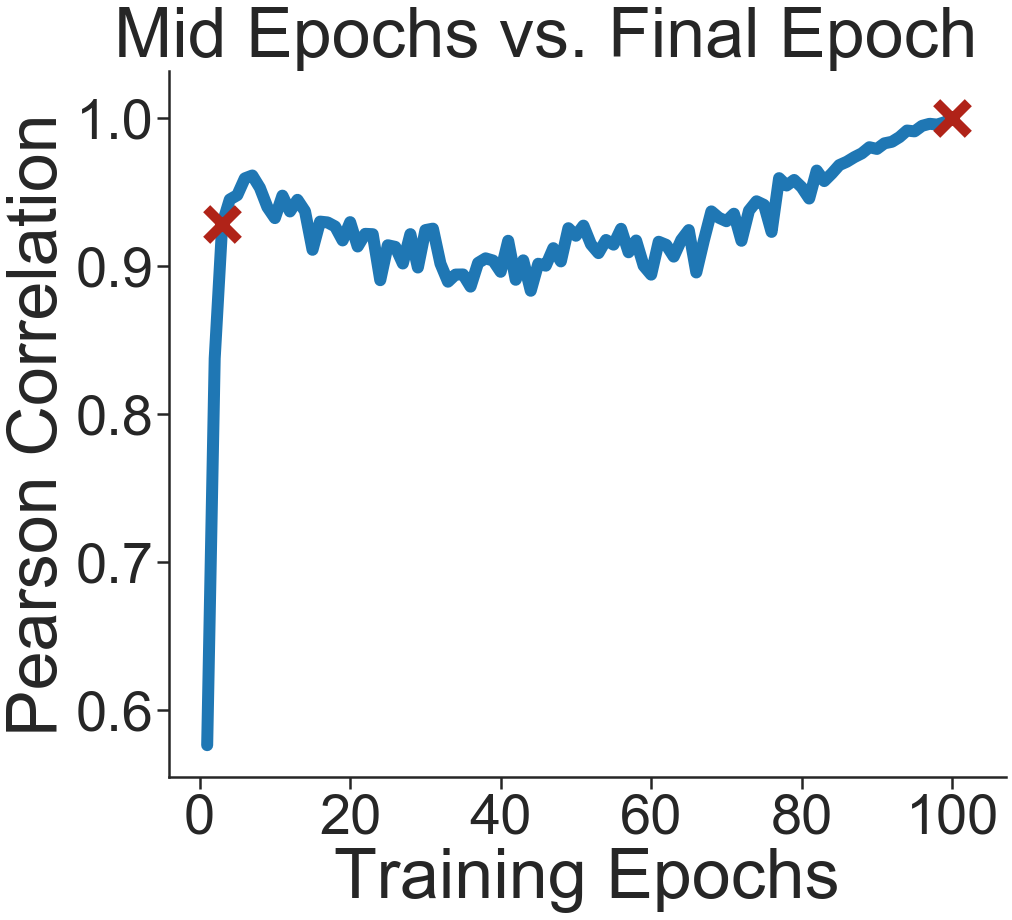

In [111]:
current_palette = sns.color_palette()
plt.figure(figsize=(15,13))
sns.lineplot(range_all,corr_all,ci='sd', linewidth=12)
i = 2
plt.scatter(range_all[i],corr_all[i],s=1000,marker='x',c='#b02318',linewidth=10,zorder=10)
plt.scatter(range_all[-1],corr_all[-1],s=1000,marker='x',c='#b02318',linewidth=10,zorder=10)
plt.xlabel('Training Epochs', fontsize=70)
# plt.ylabel('Spearman Correlation', fontsize=48)
plt.ylabel('Pearson Correlation', fontsize=70)
plt.title('Mid Epochs vs. Final Epoch', fontsize=70,x=0.45)
plt.xticks(fontsize=56)
plt.yticks(fontsize=56)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('final_results/figs/corr_epochs.png',dpi=100,bbox_inches='tight')
plt.show()

mlp_cifar10


/Users/jiaxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


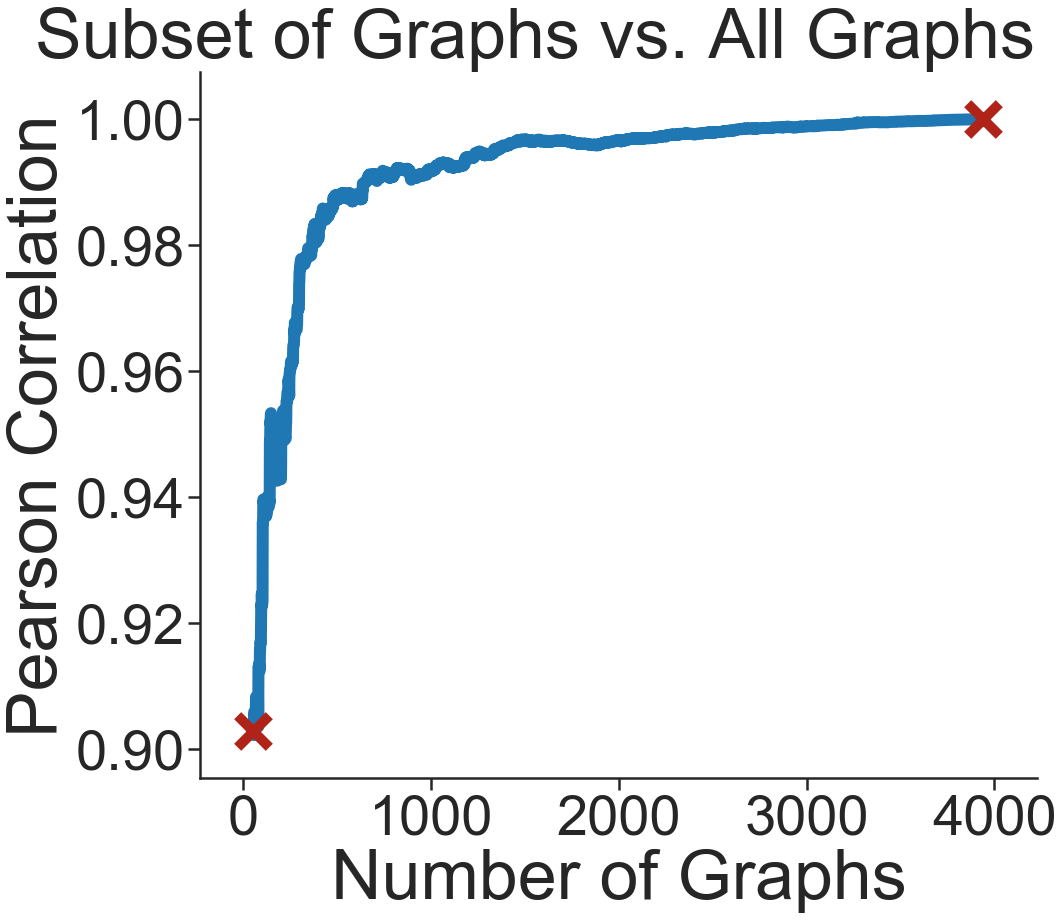

In [6]:
######### (3) Correlation over different number of graphs
def corr_graphs(trainseed_num, names_all, results_all):
    ## align graph_configs and experiment results

    results_mean = np.mean(results_all,axis=1)
    results_std = np.std(results_all,axis=1)
    top1_mean = results_mean[:,3]
    top1_std = results_std[:,3]
    if trainseed_num==1:
        top1_std[:] = 1


    top1_baseline_mean = float(top1_mean[names_all[:,0]=='linear'])
    top1_baseline_std = float(top1_std[names_all[:,0]=='linear'])
    best = np.argmin(top1_mean)
    order = np.argsort(top1_mean)

    ### View results over different number of graphs
    ## 52 graphs: ImangeNet experiments
    graph_configs = np.load('graphs_n64_52.npy')

    graph_configs = graph_configs[graph_configs[:,1]<1,:]
    result_final = []
    count = 0
    graph_configs_missing = []
    for i in range(graph_configs.shape[0]):
        key = [str(float(round(graph_configs[i,1],6))), str(float(round(graph_configs[i,2],6))), 'sum', str(round(graph_configs[i,3],0))]
        loc = np.where((names_all[:,4:8] == key).all(axis=1))[0]
        if len(loc)>0:
            temp = np.zeros(graph_configs.shape[1]+2)
            temp[:graph_configs.shape[1]] = graph_configs[i,:]
            temp[graph_configs.shape[1]:] = [top1_mean[loc], top1_std[loc]]
            result_final.append(temp)
            count += 1
        else:
            print('not found', key)
            graph_configs_missing.append(i)
    result_final = np.stack(result_final,axis=0)
    result_final_52 = result_final

    ## 3942-52 graphs
    graph_configs_52 = np.load('graphs_n64_52.npy')
    graph_configs_3942 = np.load('graphs_n64_3942.npy')
    graph_configs_52_list = graph_configs_52.tolist()
    graph_configs_3942_list = graph_configs_3942.tolist()
    filter = []
    for i in range(3942):
        find = False
        for j in range(52):
            if graph_configs_52_list[j] == graph_configs_3942_list[i]:
                find = True
                break
        if find:
            continue
        filter.append(i)
    graph_configs = graph_configs_3942[filter]


    graph_configs = graph_configs[graph_configs[:,1]<1,:]
    result_final = []
    count = 0
    graph_configs_missing = []
    for i in range(graph_configs.shape[0]):
        key = [str(float(round(graph_configs[i,1],6))), str(float(round(graph_configs[i,2],6))), 'sum', str(round(graph_configs[i,3],0))]
        loc = np.where((names_all[:,4:8] == key).all(axis=1))[0]
        if len(loc)>0:
            temp = np.zeros(graph_configs.shape[1]+2)
            temp[:graph_configs.shape[1]] = graph_configs[i,:]
            temp[graph_configs.shape[1]:] = [top1_mean[loc], top1_std[loc]]
            result_final.append(temp)
            count += 1
        else:
            print('not found', key)
            graph_configs_missing.append(i)
    result_final = np.stack(result_final,axis=0)
    result_final_3890 = result_final

    
    ######### bin subsample and plot ##########

    # filter to 52 graphs, if necessary
    graph_configs_filter = np.load('graphs_n64_52.npy')
    # # 52 graphs
    bins_clustering = np.linspace(0,1,15+1) # clustering
    bins_path = np.linspace(1,4.5,15+1) # path
    bins_sparsity = np.linspace(0,1,15+1) # sparsity

    # clustering: 4; path: 5
    digits_clustering_52 = np.digitize(result_final_52[:,4],bins_clustering)
    digits_path_52 = np.digitize(result_final_52[:,5],bins_path)
    digits_sparsity_52 = np.digitize(result_final_52[:,1],bins_sparsity)

    id = np.random.permutation(3890)
    result_final_3890 = result_final_3890[id,:]
    digits_clustering_3890 = np.digitize(result_final_3890[:,4],bins_clustering)
    digits_path_3890 = np.digitize(result_final_3890[:,5],bins_path)
    digits_sparsity_3890 = np.digitize(result_final_3890[:,1],bins_sparsity)


    result_mean_all = []
    for new in range(3891):
        ### path, clustering
        result_sum = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
        result_count = np.zeros((len(bins_path)+1, len(bins_clustering)+1))
        for i in range(digits_clustering_52.shape[0]):
            result_sum[digits_path_52[i], digits_clustering_52[i]] += result_final_52[i,-2]
            result_count[digits_path_52[i], digits_clustering_52[i]] += 1
        for i in range(new):
            result_sum[digits_path_3890[i], digits_clustering_3890[i]] += result_final_3890[i,-2]
            result_count[digits_path_3890[i], digits_clustering_3890[i]] += 1
        result_mean = result_sum/result_count

        ### IF filter to 52 graphs
        digits_clustering_filter = np.digitize(graph_configs_filter[:,-2],bins_clustering)
        digits_path_filter = np.digitize(graph_configs_filter[:,-1],bins_path)
        result_mean_filtered = np.empty((len(bins_path)+1, len(bins_clustering)+1))
        result_mean_filtered[:] = np.nan
        for i in range(graph_configs_filter.shape[0]):
            result_mean_filtered[digits_path_filter[i],digits_clustering_filter[i]] = result_mean[digits_path_filter[i],digits_clustering_filter[i]]
        result_mean = result_mean_filtered
        result_mean_all.append(result_mean[~np.isnan(result_mean)])

        
    corr_all = []
    for i in range(3891):
        corr_all.append(sp.stats.pearsonr(result_mean_all[i],result_mean_all[-1])[0])
    return corr_all


print('mlp_cifar10')
trainseed_num = 5
names_all = np.load('final_results/mlp_cifar10/names_mlp_cifar10_epoch200.npy')
results_all = np.load('final_results/mlp_cifar10/results_mlp_cifar10_epoch200.npy')

corr_all = corr_graphs(5,names_all,results_all)
range_all = list(range(52,3943))

sns.set_context("poster")
sns.set_style("ticks")
current_palette = sns.color_palette()

plt.figure(figsize=(15,13))
sns.lineplot(range_all,corr_all,ci='sd', linewidth=12)
i = 0
plt.scatter(range_all[i],corr_all[i],s=1000,marker='x',c='#b02318',linewidth=10,zorder=10)
plt.scatter(range_all[-1],corr_all[-1],s=1000,marker='x',c='#b02318',linewidth=10,zorder=10)
plt.xlabel('Number of Graphs', fontsize=70)
# plt.ylabel('Spearman Correlation', fontsize=48)
plt.ylabel('Pearson Correlation', fontsize=70)
# plt.title('5-layer FFN on Cifar-10', fontsize=70)
plt.title('Subset of Graphs vs. All Graphs', fontsize=70,x=0.4)
plt.xticks([0,1000,2000,3000,4000], fontsize=56)
plt.yticks(fontsize=56)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('final_results/figs/corr_graphs.png',dpi=100,bbox_inches='tight')
plt.show()